In [1376]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
import h5py as h5
import astropy.units as u
import pandas as pd

from matplotlib import rc
from   astropy.cosmology import WMAP9 as cosmology

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append(os.getcwd() + '/Scripts')

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
# plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['font.sans-serif'] = 'serif'
# plt.rcParams['mathtext.fontset'] = 'stix'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_85830/444440377.py:33: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1352]:
path_to_ab_data = '/Volumes/T7/COMPAS_data/final_alpha_CE_beta/'
path_to_sr_data = '/Volumes/T7/COMPAS_data/final_sigma_remnant_prescription/'

# Get paths for the data files in the $\alpha_{\textrm{CE}}$ and $\beta$ grid

In [24]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths_ab = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths_ab[alpha] = {}
    for beta in beta_vals:
        condensed_paths_ab[alpha][beta] = path_to_ab_data + 'output_alpha_CE_' + alpha + '_beta_' + beta + '/COMPAS_Output_Weighted.h5'

In [25]:
sigma_vals = ['30', '265', '750'] # All the alpha values
rmp_vals = ['D', 'M', 'R'] # All the beta values

condensed_paths_sr = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for velocity_dispersion in sigma_vals:
    condensed_paths_sr[velocity_dispersion] = {}
    for remnant_mass_p in rmp_vals:
        condensed_paths_sr[velocity_dispersion][remnant_mass_p] = path_to_sr_data + 'output_sigma_' + velocity_dispersion + '_remnant_prescription_' + remnant_mass_p + '/COMPAS_Output_Weighted.h5'

# Merger Rates $R(z)$

Define parameters for the merger rate calculation

In [26]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
weight_column   = 'mixture_weight'
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 * (1 + max_redshift_detection)
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5     # * u.Msun 
m1_max          = 150   # * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

# Van Son 2022 prescriptions:
mu0             = 0.025
muz             = -0.048
sigma0          = 1.125
sigmaz          = 0.048
alpha           = -1.77

aSF             = 0.02
bSF             = 1.48 
cSF             = 4.45 
dSF             = 5.9

# MY FIDUCIAL MSSFR PRESCRIPTIONS
lognormal=False                                     # !!! IF THIS PARAMETER IS FALSE, IT WILL USE THE NON-LOGNORMAL MSSFR PRESCRIPTIONS !!!
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None

In [27]:
plt.style.use('ggplot')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_colors = len(alpha_vals)
counter = 0
color_grid_ab = {}
marker_grid_ab = {}
linestyle_grid_ab = {}
for alpha_index, alpha_val in enumerate(alpha_vals):
    color_grid_ab[alpha_val] = {}
    marker_grid_ab[alpha_val] = {}
    linestyle_grid_ab[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        if alpha_index == 0:
            color_grid_ab[alpha_val][beta_val] = '#FF8456'
        elif alpha_index == 3:
            color_grid_ab[alpha_val][beta_val] = colors[5]
        else:
            color_grid_ab[alpha_val][beta_val] = colors[alpha_index]

        if beta_val == '0.25':
            linestyle_grid_ab[alpha_val][beta_val] = 'solid'
            marker_grid_ab[alpha_val][beta_val] = 'o'
        elif beta_val == '0.5':
            linestyle_grid_ab[alpha_val][beta_val] = 'dashed'
            marker_grid_ab[alpha_val][beta_val] = '^'
        elif beta_val == '0.75':
            linestyle_grid_ab[alpha_val][beta_val] = 'dashdot'
            marker_grid_ab[alpha_val][beta_val] = '*'

In [1353]:
plt.style.use('ggplot')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_colors = len(sigma_vals)
counter = 0
color_grid_sr = {}
marker_grid_sr = {}
linestyle_grid_sr = {}
for sigma_index, sigma_val in enumerate(sigma_vals):
    color_grid_sr[sigma_val] = {}
    marker_grid_sr[sigma_val] = {}
    linestyle_grid_sr[sigma_val] = {}
    for rmp_index, rmp_val in enumerate(rmp_vals):
        if sigma_index == 0:
            color_grid_sr[sigma_val][rmp_val] = colors[6]
        elif sigma_index == 1:
            color_grid_sr[sigma_val][rmp_val] = colors[3]
        else:
            color_grid_sr[sigma_val][rmp_val] = '#6085ff'

        if rmp_val == 'D':
            linestyle_grid_sr[sigma_val][rmp_val] = 'solid'
            marker_grid_sr[sigma_val][rmp_val] = 'o'
        elif rmp_val == 'M':
            linestyle_grid_sr[sigma_val][rmp_val] = 'dashed'
            marker_grid_sr[sigma_val][rmp_val] = '^'
        elif rmp_val == 'R':
            linestyle_grid_sr[sigma_val][rmp_val] = 'dashdot'
            marker_grid_sr[sigma_val][rmp_val] = '*'

plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [71]:
def add_lookback_t_axes(ax, labelsize=15, z_range=[0, 10], no_label=False):
    ax2  = ax.twiny()
    # second x-axis for age
    # axes2.xaxis.labelpad = 20
    ax2.tick_params(labelsize=labelsize*0.9)
    redshifts = np.linspace(0,10,100)
    #strolger works in age not redshift
    ages      = cosmology.age(redshifts).value
    #find nearest redshift to age
    agelabels = np.array([1,2,3,4,5,7, 9]) # Gyr
    ageUniverse = cosmology.age(0)
    redshiftTicks = np.zeros(len(agelabels))
    for nr, age in enumerate(agelabels):
        distance = np.abs(ages-age)
        # distance = np.abs(ages-age+cosmology.age(np.array([10])).value[0])
        ind      = np.where(distance==np.min(distance))[0][0]
        redshiftTicks[nr] =  redshifts[ind]

    ax2.set_xlim(z_range)
    ax2.set_xticks(redshiftTicks)
    ax2.set_xticklabels(agelabels)
    if not no_label:
        nameX2 = r'\textbf{Age Universe [Gyr]}'
        ax2.set_xlabel(nameX2, fontsize=labelsize, labelpad=10)
    return ax2

# All Merger Rates in a 6 Panel Plots

In [72]:
def get_all_rates(condensed_paths_ab, alpha_vals, beta_vals, condensed_paths_sr, sigma_vals, rmp_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, figsize=(20, 7), show_legend=True, bbox_to_anchor=(0.875, 1.25),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_merger_rates = {}
    total_formation_rates = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for grid in ['ab', 'sr']:

        # Make the dictionary "2D"
        total_merger_rates[grid] = {}
        total_formation_rates[grid] = {}
        Mc_bins[grid] = {}
        one_sigma[grid] = {}
        two_sigma[grid] = {}
        redshifts[grid] = {}

        # Which param grid we want to do
        if grid == 'ab':
            p1_vals = alpha_vals
            p2_vals = beta_vals
            path_to_data = path_to_ab_data
            file_string = '{}output_alpha_CE_{}_beta_{}/Pickled_Rates/MSSFR_111/{}/rates_and_bootstraps.h5'
        elif grid == 'sr':
            p1_vals = sigma_vals
            p2_vals = rmp_vals
            path_to_data = path_to_sr_data
            file_string = '{}output_sigma_{}_remnant_prescription_{}/Pickled_Rates/MSSFR_111/{}/rates_and_bootstraps.h5'

        for p1_index, p1_val in enumerate(p1_vals):
            # Make the dictionary "2D"
            total_merger_rates[grid][p1_val] = {}
            total_formation_rates[grid][p1_val] = {}
            Mc_bins[grid][p1_val] = {}
            one_sigma[grid][p1_val] = {}
            two_sigma[grid][p1_val] = {}
            redshifts[grid][p1_val] = {}

            for p2_index, p2_val in enumerate(p2_vals):
                one_sigma[grid][p1_val][p2_val] = {}
                two_sigma[grid][p1_val][p2_val] = {}

                with open(file_string.format(path_to_data, p1_val, p2_val, dco_type), 'rb') as f:
                    # Get data
                    h5_data = h5.File(f)
                    total_merger_rates[grid][p1_val][p2_val] = h5_data['Actual']['total_merger_rates'][...]
                    total_formation_rates[grid][p1_val][p2_val] = h5_data['Actual']['total_formation_rates'][...]
                    redshifts[grid][p1_val][p2_val] = h5_data['Actual']['redshifts'][...]

                    # Calculate confidence intervals
                    one_sigma[grid][p1_val][p2_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                    one_sigma[grid][p1_val][p2_val]['total_formation_rates']             =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                    one_sigma[grid][p1_val][p2_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                    # Get the two sigma confidence intervals
                    two_sigma[grid][p1_val][p2_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                    two_sigma[grid][p1_val][p2_val]['total_formation_rates']             =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                    two_sigma[grid][p1_val][p2_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

    return redshifts, total_formation_rates, total_merger_rates, one_sigma, two_sigma

In [1295]:
def plot_all_rates(redshifts, all_total_merger_rates, one_sigma, two_sigma, alpha_vals, beta_vals, sigma_vals, rmp_vals, rate_type, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, figsize=(30, 75), show_legend=True, bbox_to_anchor=(0.875, 1.25),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel00_range=None, panel01_range=None, panel10_range=None, panel11_range=None, panel20_range=None, panel21_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(3, 2, figsize=figsize)

    # Arrays for the handles
    legend_handles_ab = []
    legend_labels_ab = []
    legend_handles_sr = []
    legend_labels_sr = []

    for i_grid, grid in enumerate(['ab', 'sr']):

        # Check vars for grid
        if grid == 'ab':
            color_grid = color_grid_ab
            marker_grid = marker_grid_ab
            linestyle_grid = linestyle_grid_ab
            p1_vals = alpha_vals
            p2_vals = beta_vals
            label_fstring = r'$\alpha_{{\textrm{{CE}}}} = ${}  $\beta = ${}'
        else:
            color_grid = color_grid_sr
            marker_grid = marker_grid_sr
            linestyle_grid = linestyle_grid_sr
            p1_vals = sigma_vals
            p2_vals = rmp_vals
            label_fstring = r'$\sigma_{{\textrm{{rms}}}}^{{1D}} = ${} $\textrm{{ RMP}} = ${}'


        for i_p, dco_t in enumerate(('BBH', 'BHNS', 'BNS')):
            if dco_t == 'BBH':
                marker_period = 10
            else:
                marker_period = 1000

            # Get redshifts to use for the SFR
            sfr_redshifts = redshifts[dco_t][grid][p1_vals[0]][p2_vals[0]]

            # Retreive the SFR
            MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
            MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
            ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
            sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
            sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
            sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
            
            for p1_val in p1_vals:
                for p2_val in p2_vals:
                    if i_p == 0:
                        axes[i_p, i_grid].plot(redshifts[dco_t][grid][p1_val][p2_val], all_total_merger_rates[dco_t][grid][p1_val][p2_val], lw=lw, label=label_fstring.format(p1_val, p2_val), color=color_grid[p1_val][p2_val], marker=marker_grid[p1_val][p2_val], mec='k', mfc=color_grid[p1_val][p2_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[p1_val][p2_val], markeredgewidth=0.7)
                    else:
                        axes[i_p, i_grid].plot(redshifts[dco_t][grid][p1_val][p2_val], all_total_merger_rates[dco_t][grid][p1_val][p2_val], lw=lw, color=color_grid[p1_val][p2_val], marker=marker_grid[p1_val][p2_val], mec='k', mfc=color_grid[p1_val][p2_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[p1_val][p2_val], markeredgewidth=0.7)

                    if rate_type == 'merge':
                        axes[i_p, i_grid].fill_between(x=redshifts[dco_t][grid][p1_val][p2_val], y1=one_sigma[dco_t][grid][p1_val][p2_val]['total_merger_rates'][0], y2=one_sigma[dco_t][grid][p1_val][p2_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[p1_val][p2_val])
                        axes[i_p, i_grid].fill_between(x=redshifts[dco_t][grid][p1_val][p2_val], y1=two_sigma[dco_t][grid][p1_val][p2_val]['total_merger_rates'][0], y2=two_sigma[dco_t][grid][p1_val][p2_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[p1_val][p2_val])
                    elif rate_type == 'form':
                        axes[i_p, i_grid].fill_between(x=redshifts[dco_t][grid][p1_val][p2_val], y1=one_sigma[dco_t][grid][p1_val][p2_val]['total_formation_rates'][0], y2=one_sigma[dco_t][grid][p1_val][p2_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[p1_val][p2_val])
                        axes[i_p, i_grid].fill_between(x=redshifts[dco_t][grid][p1_val][p2_val], y1=two_sigma[dco_t][grid][p1_val][p2_val]['total_formation_rates'][0], y2=two_sigma[dco_t][grid][p1_val][p2_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[p1_val][p2_val])

                    # Label axes of all the plots
                    if rate_type == 'merge':
                        axes[i_p, i_grid].set_ylabel(r'\textbf{$R_{\rm{merge}}(z) \ \ [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
                    elif rate_type == 'form':
                        axes[i_p, i_grid].set_ylabel(r'\textbf{$R_{\rm{form}}(z) \ \ [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
        
        # After the plotting in the loop, store the legend information
        if grid == 'ab':
            handles, labels = axes[0, i_grid].get_legend_handles_labels()
            legend_handles_ab.extend(handles)
            legend_labels_ab.extend(labels)
        else:
            handles, labels = axes[0, i_grid].get_legend_handles_labels()
            legend_handles_sr.extend(handles)
            legend_labels_sr.extend(labels)



    # Set lower bounds for the plots
    if panel00_range:
        axes[0, 0].set_ylim(panel00_range)
    if panel01_range:
        axes[0, 1].set_ylim(panel01_range)
    if panel10_range:
        axes[1, 0].set_ylim(panel10_range)
    if panel11_range:
        axes[1, 1].set_ylim(panel11_range)
    if panel20_range:
        axes[2, 0].set_ylim(panel20_range)
    if panel21_range:
        axes[2, 1].set_ylim(panel21_range)
    
    for i_p in range(3):
        for i_grid in [0, 1]:
            # Scale SFR differently for each DCO type
            sfr = sfr/max(sfr)
            merger_const = axes[i_p, i_grid].get_ylim()[1] * 0.3

            # Plot SFRs
            sfr_line = axes[i_p, i_grid].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
    legend3 = axes[0, 0].legend(sfr_line, ["SFRD (scaled)"], fontsize=22, loc='upper right')

    axes[2, 0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[2, 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
        ax.set_yscale('log')
        redshift_ticks = np.arange(1, 10, 1)
        ax.xaxis.set_ticks(redshift_ticks)
        ax.set_xlim((0,10))
        ax.grid()

    # Plot horizontal line for SFR on the normalized plots
    axes[0, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[1, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[2, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)

    # Include legend
    if show_legend:

        # Separate legends
        if legend_handles_ab:
            leg = axes[0, 0].legend(legend_handles_ab, legend_labels_ab, fontsize=14.4, ncol=3, bbox_to_anchor=(-0.16, 1.25), markerscale=1, loc='lower left', columnspacing=3.7)
            for legobj in leg.legendHandles:
                legobj.set_linewidth(3.0)
        if legend_handles_sr:
            leg = axes[0, 1].legend(legend_handles_sr, legend_labels_sr, fontsize=14.4, ncol=3, bbox_to_anchor=(-0.16575, 1.25), markerscale=1, loc='lower left', columnspacing=2)
            for legobj in leg.legendHandles:
                legobj.set_linewidth(3.0)
        else: # one big
            leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.0, 1.2),  markerscale=1) 
            for legobj in leg.legendHandles:
                legobj.set_linewidth(3.0)
    axes[0, 0].add_artist(legend3)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0, 0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[0, 1], labelsize=fs)
    ax_middle1 = add_lookback_t_axes(axes[1, 0], labelsize=fs, no_label=True)
    ax_middle2 = add_lookback_t_axes(axes[1, 1], labelsize=fs, no_label=True)
    ax_bottom1 = add_lookback_t_axes(axes[2, 0], labelsize=fs, no_label=True)
    ax_bottom2 = add_lookback_t_axes(axes[2, 1], labelsize=fs, no_label=True)
    for ax_top in (ax_top1, ax_top2):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    # Add DCO type text boxes
    props = dict(boxstyle='round', facecolor='lightgrey', alpha=1.)
    for i, txt in enumerate((r'\textbf{BBH}', r'\textbf{BHNS}', r'\textbf{BNS}')):
        axes[i, 1].text(0.966, 0.925, txt, fontsize=40, transform=axes[i, 1].transAxes,
            verticalalignment='top', horizontalalignment='right', bbox=props)

    # Show the plot!
    # plt.tight_layout()
    # plt.show()
    plt.subplots_adjust(hspace=0.245, wspace=0.175)  # Adjust this value as needed

In [1270]:
redshifts, total_formation_rates, total_merger_rates, one_sigma, two_sigma = {}, {}, {}, {}, {}

for dco_t in ('BNS', 'BHNS', 'BBH'):
    redshifts[dco_t], total_formation_rates[dco_t], total_merger_rates[dco_t], one_sigma[dco_t], two_sigma[dco_t] = get_all_rates(condensed_paths_ab, alpha_vals, beta_vals, condensed_paths_sr, sigma_vals, rmp_vals, dco_type=dco_t, weight_column=weight_column,
                merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                max_redshift_detection=max_redshift_detection,
                redshift_step=redshift_step, z_first_SF=z_first_SF,
                m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                sensitivity=sensitivity, snr_threshold=snr_threshold,
                Mc_max=Mc_max, Mc_step=Mc_step,
                eta_max=eta_max, eta_step=eta_step,
                snr_max=snr_max, snr_step=snr_step, 
                lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                panel1_range=(10**0.25, 10**4.1), panel2_range=(10**-1, 10**0.5), show_legend=False, figsize=(20,7), bbox_to_anchor=(0.875, 1.25))

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRpres

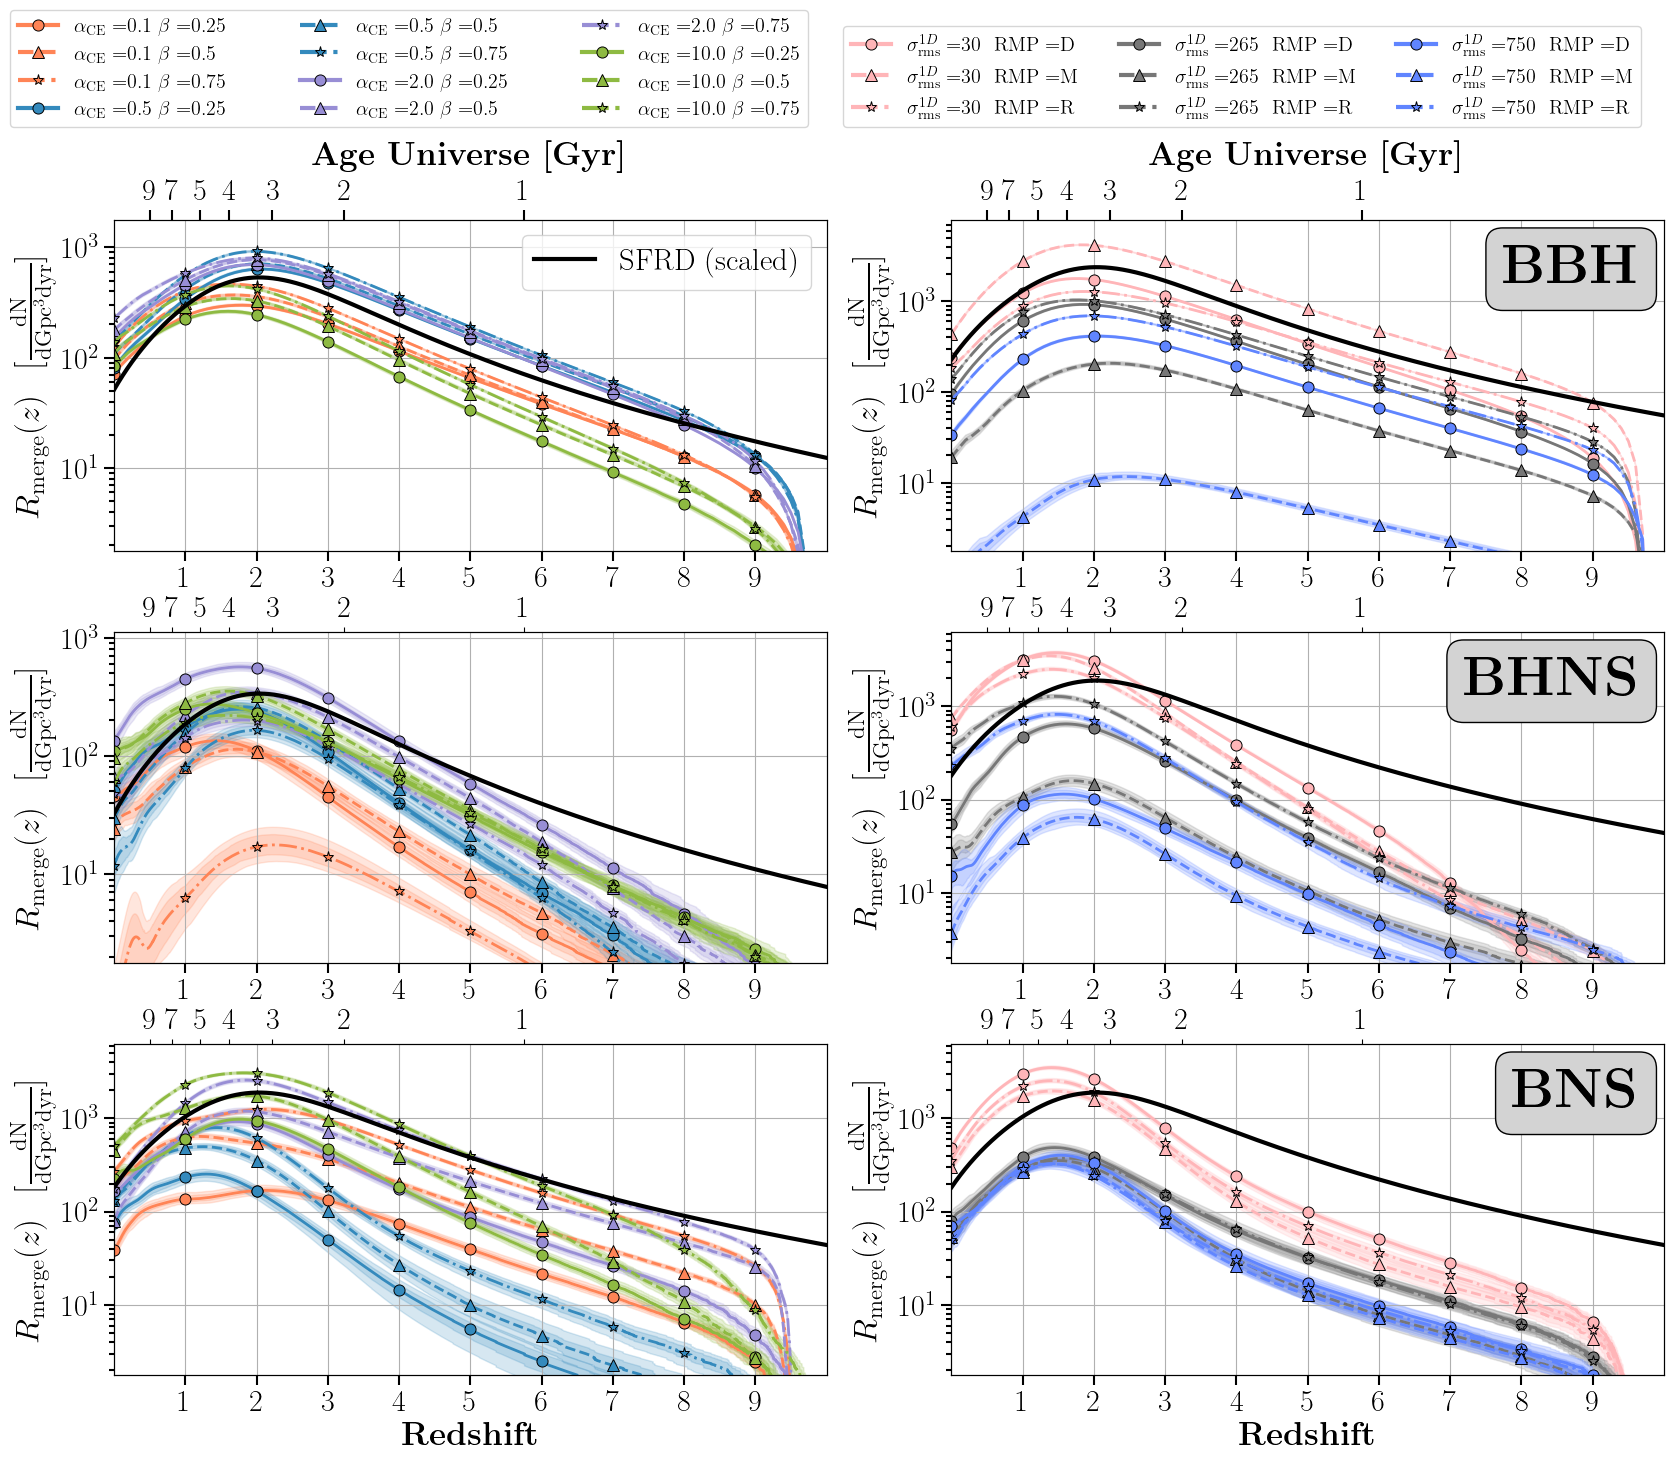

In [1296]:
plot_all_rates(redshifts, total_merger_rates, one_sigma, two_sigma, alpha_vals, beta_vals, sigma_vals, rmp_vals, rate_type='merge', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel00_range=(10**0.25, 10**3.25), panel10_range=(10**0.25, 10**3.05), panel20_range=(10**0.25, 10**3.8), panel01_range=(10**0.25, 10**3.9), panel11_range=(10**0.25, 10**3.8), panel21_range=(10**0.25, 10**3.8), show_legend=True, figsize=(20,15), bbox_to_anchor=(0.88, 1.11))

plt.savefig('Figures/all_merger_rates.pdf', bbox_inches="tight")
plt.show()

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


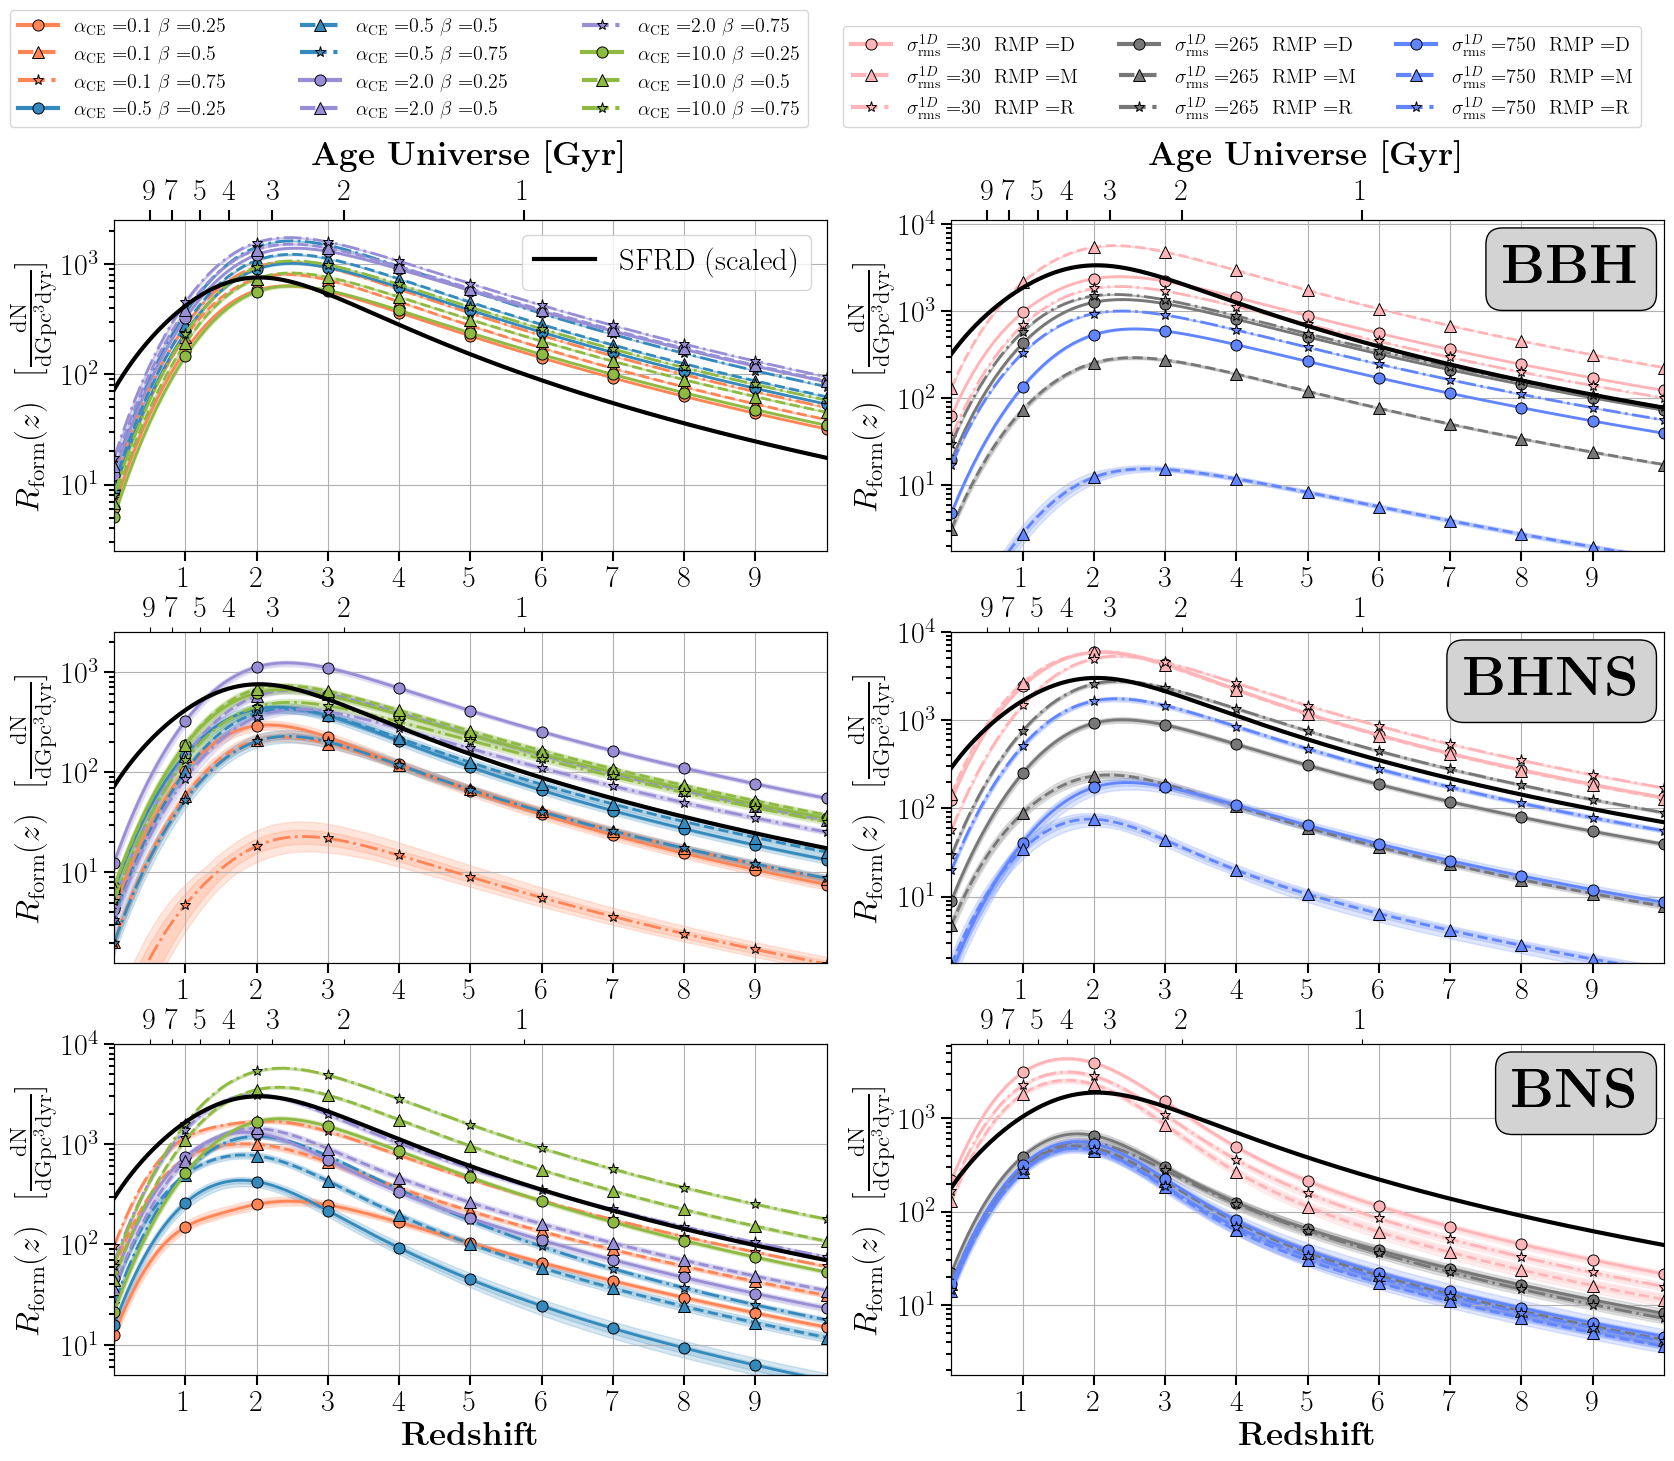

In [1297]:
plot_all_rates(redshifts, total_formation_rates, one_sigma, two_sigma, alpha_vals, beta_vals, sigma_vals, rmp_vals, rate_type='form', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel00_range=(10**0.4, 10**3.4), panel10_range=(10**0.1, 10**3.4), panel20_range=(10**0.7, 10**4.0), panel01_range=(10**0.25, 10**4.05), panel11_range=(10**0.25, 10**4.0), panel21_range=(10**0.25, 10**3.8), show_legend=True, figsize=(20,15), bbox_to_anchor=(0.88, 1.11))

plt.savefig('Figures/all_formation_rates.pdf', bbox_inches="tight")
plt.show()

# Double Broken Power Law Fits

In [279]:
color_grid_dcos = {
    'BBH': '#4F81BD',
    'BHNS': '#9BBB59',
    'BNS': '#F79646'
}

In [515]:
test = [1,2,3,4,5,6,7,8,9]
test[:2] + test[3:6] + test[7:]

[1, 2, 4, 5, 6, 8, 9]

In [578]:
def dbl_brkn_pow_law(redshifts, kappa0, kappa1, kappa2, max_index, R0):

    # Index of the first break
    break_index=int(max_index / 2)

    # Data broken up
    broken_redshifts = [redshifts[:break_index], redshifts[break_index:max_index], redshifts[max_index:]]

    # Calculate the rate
    rate0 = R0 * (1+broken_redshifts[0]) ** kappa0
    rate1 = (1+broken_redshifts[1]) ** kappa1
    rate2 = (1+broken_redshifts[2]) ** kappa2
    c_peak = 1 / (1+redshifts[max_index]) ** kappa2  # A coefficient to scale the rate after the peak
    rate = np.concatenate((rate0, rate1 * np.abs(rate0[-1] / rate1[0])))
    # rate = np.concatenate((rate, rate2 * np.abs(rate[-1] / rate2[0])))
    rate = np.concatenate((rate, rate2 * c_peak))

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):

    # Get the index of the maximum rate
    max_index = np.argmax(rate)

    # Get the peak redshift
    peak_z = redshifts[max_index]

    # Get intrinsic rate
    R0 = rate[0]

    # Fit the data
    kappas, params_cov = curve_fit(lambda zs, kappa0, kappa1, kappa2: dbl_brkn_pow_law(zs, kappa0, kappa1, kappa2, max_index, R0), redshifts, rate)


    return kappas, peak_z

In [579]:
def get_pow_law_fits(path_to_data, file_string, p1_vals, p2_vals):

    # Dictionaries to retrieve the data:
	total_formation_rates = {}
	total_merger_rates = {}
	one_sigma = {}
	two_sigma = {}
	formation_rate_kappa0 = {}
	formation_rate_kappa1 = {}
	formation_rate_kappa2 = {}
	merger_rate_kappa0 = {}
	merger_rate_kappa1 = {}
	merger_rate_kappa2 = {}
	formation_rate_peak_zs = {}
	merger_rate_peak_zs = {}
	redshifts = {}
	intrinsic_formation_rate = {}
	intrinsic_merger_rate = {}
	merger_rate_pred = {}
	formation_rate_pred = {}

	######################################################################
	# Retrieve the data
	index = 0
	for dco_type in ('BBH', 'BHNS', 'BNS'):
		total_formation_rates[dco_type] = {}
		total_merger_rates[dco_type] = {}
		one_sigma[dco_type] = {}
		two_sigma[dco_type] = {}
		formation_rate_kappa0[dco_type] = {}
		formation_rate_kappa1[dco_type] = {}
		formation_rate_kappa2[dco_type] = {}
		merger_rate_kappa0[dco_type] = {}
		merger_rate_kappa1[dco_type] = {}
		merger_rate_kappa2[dco_type] = {}
		formation_rate_peak_zs[dco_type] = {}
		merger_rate_peak_zs[dco_type] = {}
		redshifts[dco_type] = {}
		intrinsic_formation_rate[dco_type] = {}
		intrinsic_merger_rate[dco_type] = {}
		merger_rate_pred[dco_type] = {}
		formation_rate_pred[dco_type] = {}

		for p1_val in p1_vals:
			# Make the dictionary "2D"
			total_formation_rates[dco_type][p1_val] = {}
			total_merger_rates[dco_type][p1_val] = {}
			one_sigma[dco_type][p1_val] = {}
			two_sigma[dco_type][p1_val] = {}
			formation_rate_kappa0[dco_type][p1_val] = {}
			formation_rate_kappa1[dco_type][p1_val] = {}
			formation_rate_kappa2[dco_type][p1_val] = {}
			merger_rate_kappa0[dco_type][p1_val] = {}
			merger_rate_kappa1[dco_type][p1_val] = {}
			merger_rate_kappa2[dco_type][p1_val] = {}
			formation_rate_peak_zs[dco_type][p1_val] = {}
			merger_rate_peak_zs[dco_type][p1_val] = {}
			redshifts[dco_type][p1_val] = {}         
			intrinsic_formation_rate[dco_type][p1_val] = {}
			intrinsic_merger_rate[dco_type][p1_val] = {}
			merger_rate_pred[dco_type][p1_val] = {}
			formation_rate_pred[dco_type][p1_val] = {}

			for p2_val in p2_vals:
				one_sigma[dco_type][p1_val][p2_val] = {}
				two_sigma[dco_type][p1_val][p2_val] = {}
				with open(file_string.format(path_to_data, p1_val, p2_val, dco_type), 'rb') as f:

					# Get data
					h5_data = h5.File(f)
					total_formation_rates[dco_type][p1_val][p2_val] = h5_data['Actual']['total_formation_rates'][...]
					total_merger_rates[dco_type][p1_val][p2_val] = h5_data['Actual']['total_merger_rates'][...]
					redshifts[dco_type][p1_val][p2_val] = h5_data['Actual']['redshifts'][...]

					# GET RATE KAPPAS, Z_PEAK, AND R0                                
					# Get the intrinsic rates
					intrinsic_formation_rate[dco_type][p1_val][p2_val] = total_formation_rates[dco_type][p1_val][p2_val][0]
					intrinsic_merger_rate[dco_type][p1_val][p2_val] = total_merger_rates[dco_type][p1_val][p2_val][0]

					# Get kappas
					# Formation rates
					formation_rate_kappas, formation_rate_peak_z = dbl_get_kappa_and_peak(redshifts[dco_type][p1_val][p2_val],  total_formation_rates[dco_type][p1_val][p2_val]/max(total_formation_rates[dco_type][p1_val][p2_val]))
					formation_rate_peak_zs[dco_type][p1_val][p2_val] = formation_rate_peak_z
					formation_rate_kappa0[dco_type][p1_val][p2_val] = formation_rate_kappas[0]
					formation_rate_kappa1[dco_type][p1_val][p2_val] = formation_rate_kappas[1]
					formation_rate_kappa2[dco_type][p1_val][p2_val] = formation_rate_kappas[2]
					# Merger rates
					merger_rate_kappas, merger_rate_peak_z = dbl_get_kappa_and_peak(redshifts[dco_type][p1_val][p2_val],  total_merger_rates[dco_type][p1_val][p2_val]/max(total_merger_rates[dco_type][p1_val][p2_val]))
					merger_rate_peak_zs[dco_type][p1_val][p2_val] = merger_rate_peak_z
					merger_rate_kappa0[dco_type][p1_val][p2_val] = merger_rate_kappas[0]
					merger_rate_kappa1[dco_type][p1_val][p2_val] = merger_rate_kappas[1]
					merger_rate_kappa2[dco_type][p1_val][p2_val] = merger_rate_kappas[2]

					# Get the predictions
					formation_max_index = np.argmax(total_formation_rates[dco_type][p1_val][p2_val])
					formation_break_index=int(formation_max_index / 2)
					formation_R0 = (total_formation_rates[dco_type][p1_val][p2_val]/max(total_formation_rates[dco_type][p1_val][p2_val]))[0]
					formation_rate_pred[dco_type][p1_val][p2_val] = dbl_brkn_pow_law(redshifts[dco_type][p1_val][p2_val], formation_rate_kappas[0], formation_rate_kappas[1], formation_rate_kappas[2], formation_max_index, formation_R0)
					merger_max_index = np.argmax(total_merger_rates[dco_type][p1_val][p2_val])
					merger_break_index=int(merger_max_index / 2)
					merger_R0 = (total_merger_rates[dco_type][p1_val][p2_val]/max(total_merger_rates[dco_type][p1_val][p2_val]))[0]
					merger_rate_pred[dco_type][p1_val][p2_val] = dbl_brkn_pow_law(redshifts[dco_type][p1_val][p2_val], merger_rate_kappas[0], merger_rate_kappas[1], merger_rate_kappas[2], merger_max_index, merger_R0)


					# CONFIDENCE INTERVALS!
					# Iterate through all the bootstrapped rates and calculate the kappa values for the rates
					formation_rate_kappa0s = []
					formation_rate_kappa1s = []
					formation_rate_kappa2s = []
					formation_rate_peaks = []
					merger_rate_kappa0s = []
					merger_rate_kappa1s = []
					merger_rate_kappa2s = []
					merger_rate_peaks = []
					intrinsic_formation_rates = []
					intrinsic_merger_rates = []
					for rate_index in range(len(h5_data['Bootstraps']['total_formation_rates'][...])):

						# Get the akppa for the current bootstrap iteration
						if np.argmax(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]) != 0 and np.argmax(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0
							# Get the kappas and peaks
							formation_rate_kappas_bs, formation_rate_peak = dbl_get_kappa_and_peak(redshifts[dco_type][p1_val][p2_val], h5_data['Bootstraps']['total_formation_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]))
							merger_rate_kappas_bs, merger_rate_peak = dbl_get_kappa_and_peak(redshifts[dco_type][p1_val][p2_val], h5_data['Bootstraps']['total_merger_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]))

							# Store the kappas
							formation_rate_kappa0s.append(formation_rate_kappas_bs[0])
							formation_rate_kappa1s.append(formation_rate_kappas_bs[1])
							formation_rate_kappa2s.append(formation_rate_kappas_bs[2])
							merger_rate_kappa0s.append(merger_rate_kappas_bs[0])
							merger_rate_kappa1s.append(merger_rate_kappas_bs[1])
							merger_rate_kappa2s.append(merger_rate_kappas_bs[2])

							# Store the peaks
							formation_rate_peaks.append(formation_rate_peak)
							merger_rate_peaks.append(merger_rate_peak)

							# Get the intrinsic rates
							intrinsic_formation_rates.append(h5_data['Bootstraps']['total_formation_rates'][...][rate_index][0])
							intrinsic_merger_rates.append(h5_data['Bootstraps']['total_merger_rates'][...][rate_index][0])


					# Get and store the confidence intervals for the kappas
					# Formation rates
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
					# Merger rates
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])

	return (total_formation_rates, 
			total_merger_rates,
			one_sigma, two_sigma,
			formation_rate_kappa0,
			formation_rate_kappa1,
			formation_rate_kappa2,
			merger_rate_kappa0,
			merger_rate_kappa1,
			merger_rate_kappa2,
			formation_rate_peak_zs,
			merger_rate_peak_zs,
			redshifts,
			intrinsic_formation_rate,
			intrinsic_merger_rate,
			formation_rate_pred,
			merger_rate_pred)


def plot_pow_law_fits(total_formation_rates, 
        	        total_merger_rates,
        	        one_sigma,
					two_sigma,
            	    formation_rate_kappa0,
                	formation_rate_kappa1,
           		    formation_rate_kappa2,
                	merger_rate_kappa0,
            	    merger_rate_kappa1,
                	merger_rate_kappa2,
                	formation_rate_peak_zs,
                	merger_rate_peak_zs,
                	redshifts,
                	intrinsic_formation_rate,
                	intrinsic_merger_rate):

	index = 0
	dy = 0.8
	labels = []
	label_indexs = []
	dco_markers = {
		'BBH': 'o',
		'BHNS': '^',
		'BNS': '*'
	}
	dco_marker_sizes = {
		'BBH': 120,
		'BHNS': 120,
		'BNS': 185
	}


	######################################################################
	# Plot the merger rate kappas and z_peak
    # Create a figure
	merger_fig = plt.figure(figsize=(19, 17))
	# Create axes for the first row and store them in a list
	axes_first_row = [merger_fig.add_subplot(2, 5, i + 1) for i in range(5)]
	# Create axes for the second row, sharing x-axis with corresponding first row axes
	axes_second_row = [merger_fig.add_subplot(2, 5, i + 6, sharex=ax) for i, ax in enumerate(axes_first_row)]
	# Merge the two lists of axes into a 2D list
	merger_axes = np.array([axes_first_row, axes_second_row])

	# Make grid in background
	for i in range(2):
		merger_axes[i, 0].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 1].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 2].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 3].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 4].grid(alpha=0.5, zorder=-1)


	for i_grid, grid in enumerate(('ab', 'sr')):

		# Param vars based on grid
		if grid == 'ab':
			p1_vals = alpha_vals
			p2_vals = beta_vals
		else:
			p1_vals = sigma_vals
			p2_vals = rmp_vals
		dylen = (2*dy)/(len(p1_vals)*len(p2_vals))
		index = 0
		labels = []
		label_indexs = []
		legend_pts = []

		for dco_type in ('BBH', 'BHNS', 'BNS'):
			xs = []
			ys = []
			for p1_val in p1_vals:
				for p2_val in p2_vals:

					# Store the x and y values for the line plot
					xs.append([
						intrinsic_merger_rate[grid][dco_type][p1_val][p2_val],
						merger_rate_kappa0[grid][dco_type][p1_val][p2_val],
						merger_rate_kappa1[grid][dco_type][p1_val][p2_val],
						merger_rate_peak_zs[grid][dco_type][p1_val][p2_val],
						merger_rate_kappa2[grid][dco_type][p1_val][p2_val]
					])
					ys.append(index)

					# Plot the intrinsic rate
					scatter_pt = merger_axes[i_grid, 0].scatter(x=intrinsic_merger_rate[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type], label=dco_type)                                             	   	# Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 1sigma error bar
					merger_axes[i_grid, 0].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)             				# 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 2sigma error bar
					merger_axes[i_grid, 0].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)             				# 2sigma error bar

					# Plot Kappa0
					merger_axes[i_grid, 1].scatter(x=merger_rate_kappa0[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                   # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa0'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa0'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 1].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa0'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa0'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa0'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 1].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa0'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Plot Kappa1
					merger_axes[i_grid, 2].scatter(x=merger_rate_kappa1[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                   # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa1'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa1'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 2].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa1'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa1'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa1'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 2].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa1'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Plot z_max
					merger_axes[i_grid, 3].scatter(x=merger_rate_peak_zs[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                  # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 3].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 3].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Plot Kappa2
					merger_axes[i_grid, 4].scatter(x=merger_rate_kappa2[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                   # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa2'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa2'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 4].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa2'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa2'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa2'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 4].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_kappa2'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Add model values to the labels list
					if grid == 'ab':
						labels.append(r'$\alpha_{\textrm{CE}} = $' + p1_val + r'$\beta = $' + p2_val)
					else:
						labels.append(r'$\sigma_{\textrm{rms}}^{1D} = $' + p1_val + r'$\textrm{ RMP} = $' + p2_val)
					label_indexs.append(index)

					# Append point for legend
					if index == 0:
						legend_pts.append(scatter_pt)
					index+=1

			# Add lines connecting the points
			xs = np.array(xs)
			for i_line in range(5):
				merger_axes[i_grid, i_line].plot(xs[:, i_line], ys, color=color_grid_dcos[dco_type])
			index = 0

		for ax_index, ax in enumerate(merger_axes[i_grid].flatten()):
			ax.tick_params(labelsize=20)
			ax.set_yticks(label_indexs)
			if ax_index == 0:       
				ax.set_yticklabels(labels)
			else:
				ax.set_yticklabels(['' for i in range(len(labels))])


	# # Plot SFR values
	# merger_axes[1].axvline(x=sfr_kappa0, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr
	# merger_axes[2].axvline(x=sfr_kappa1, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa1 for the sfr
	# merger_axes[3].axvline(x=sfr_peak_redshift, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                    # Plot kappa0 for the sfr
	# merger_axes[4].axvline(x=sfr_kappa2, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr

	# # Add 90% confidence interval from 03 Ligo/Virgo 2022; The population of merging compact...
	# if dco_type == 'BNS':
	#         merger_axes[0].axvspan(10, 1700, alpha=0.3, color='gray', zorder=-1)
	# elif dco_type == 'BHNS':
	#         merger_axes[0].axvspan(7.8, 140, alpha=0.3, color='gray', zorder=-1)
	# elif dco_type == 'BBH':
	#         merger_axes[0].axvspan(16, 61, alpha=0.3, color='gray', zorder=-1)
	merger_axes[0, 0].set_xscale('log')
	for dco_type, lower_bound, upper_bound in zip(['BBH', 'BHNS', 'BNS'], [10, 7.8, 16], [1700, 140, 61]):
		merger_axes[0, 0].axvspan(lower_bound, upper_bound, alpha=0.3, color=color_grid_dcos[dco_type], zorder=-1)
		merger_axes[1, 0].axvspan(lower_bound, upper_bound, alpha=0.3, color=color_grid_dcos[dco_type], zorder=-1)
	xlims = merger_axes[0, 0].get_xlim()
	print(xlims[0])
	merger_axes[0, 0].set_xlim((xlims[0]-0.2, xlims[1]))


	# Label axes of all the plots
	merger_axes[1, 0].set_xlabel(r'$R_0$', fontsize=22)
	merger_axes[1, 1].set_xlabel(r'$\kappa_0$', fontsize=22)
	merger_axes[1, 2].set_xlabel(r'$\kappa_1$', fontsize=22)
	merger_axes[1, 3].set_xlabel(r'$z_\textrm{peak}$', fontsize=22)
	merger_axes[1, 4].set_xlabel(r'$\kappa_2$', fontsize=22)
	merger_axes[0, 0].set_ylabel(r'\textbf{Grid A Model}', fontsize=22)
	merger_axes[1, 0].set_ylabel(r'\textbf{Grid B Model}', fontsize=22)

	# Drop ticks on the top row
	for ax in merger_axes[0]:
		ax.tick_params(labelbottom=False)

	
	plt.tight_layout(pad=1.8)
	
	merger_axes[0, 0].legend(handles=legend_pts, fontsize=24, loc="upper left", ncol=1, edgecolor='k', handletextpad=0.4, handlelength=1.0, framealpha=1.0, borderaxespad=0.2)

In [580]:
total_formation_rates = {}
total_merger_rates = {}
one_sigma = {}
two_sigma = {}
formation_rate_kappa0 = {}
formation_rate_kappa1 = {}
formation_rate_kappa2 = {}
merger_rate_kappa0 = {}
merger_rate_kappa1 = {}
merger_rate_kappa2 = {}
formation_rate_peak_zs = {}
merger_rate_peak_zs = {}
redshifts = {}
intrinsic_formation_rate = {}
intrinsic_merger_rate = {}
formation_rate_preds = {}
merger_rate_preds = {}
file_strings = ['{}output_alpha_CE_{}_beta_{}/Pickled_Rates/MSSFR_111/{}/rates_and_bootstraps.h5', '{}output_sigma_{}_remnant_prescription_{}/Pickled_Rates/MSSFR_111/{}/rates_and_bootstraps.h5']

for grid, path, p1_vals, p2_vals, fstring in zip(['ab', 'sr'], [path_to_ab_data, path_to_sr_data], [alpha_vals, sigma_vals], [beta_vals, rmp_vals], file_strings):
    (total_formation_rates[grid],
    total_merger_rates[grid],
    one_sigma[grid],
    two_sigma[grid],
    formation_rate_kappa0[grid],
    formation_rate_kappa1[grid],
    formation_rate_kappa2[grid],
    merger_rate_kappa0[grid],
    merger_rate_kappa1[grid],
    merger_rate_kappa2[grid],
    formation_rate_peak_zs[grid],
    merger_rate_peak_zs[grid],
    redshifts[grid],
    intrinsic_formation_rate[grid],
    intrinsic_merger_rate[grid],
    formation_rate_preds[grid],
    merger_rate_preds[grid]) = get_pow_law_fits(path, fstring, p1_vals, p2_vals)

0.26826113387942313


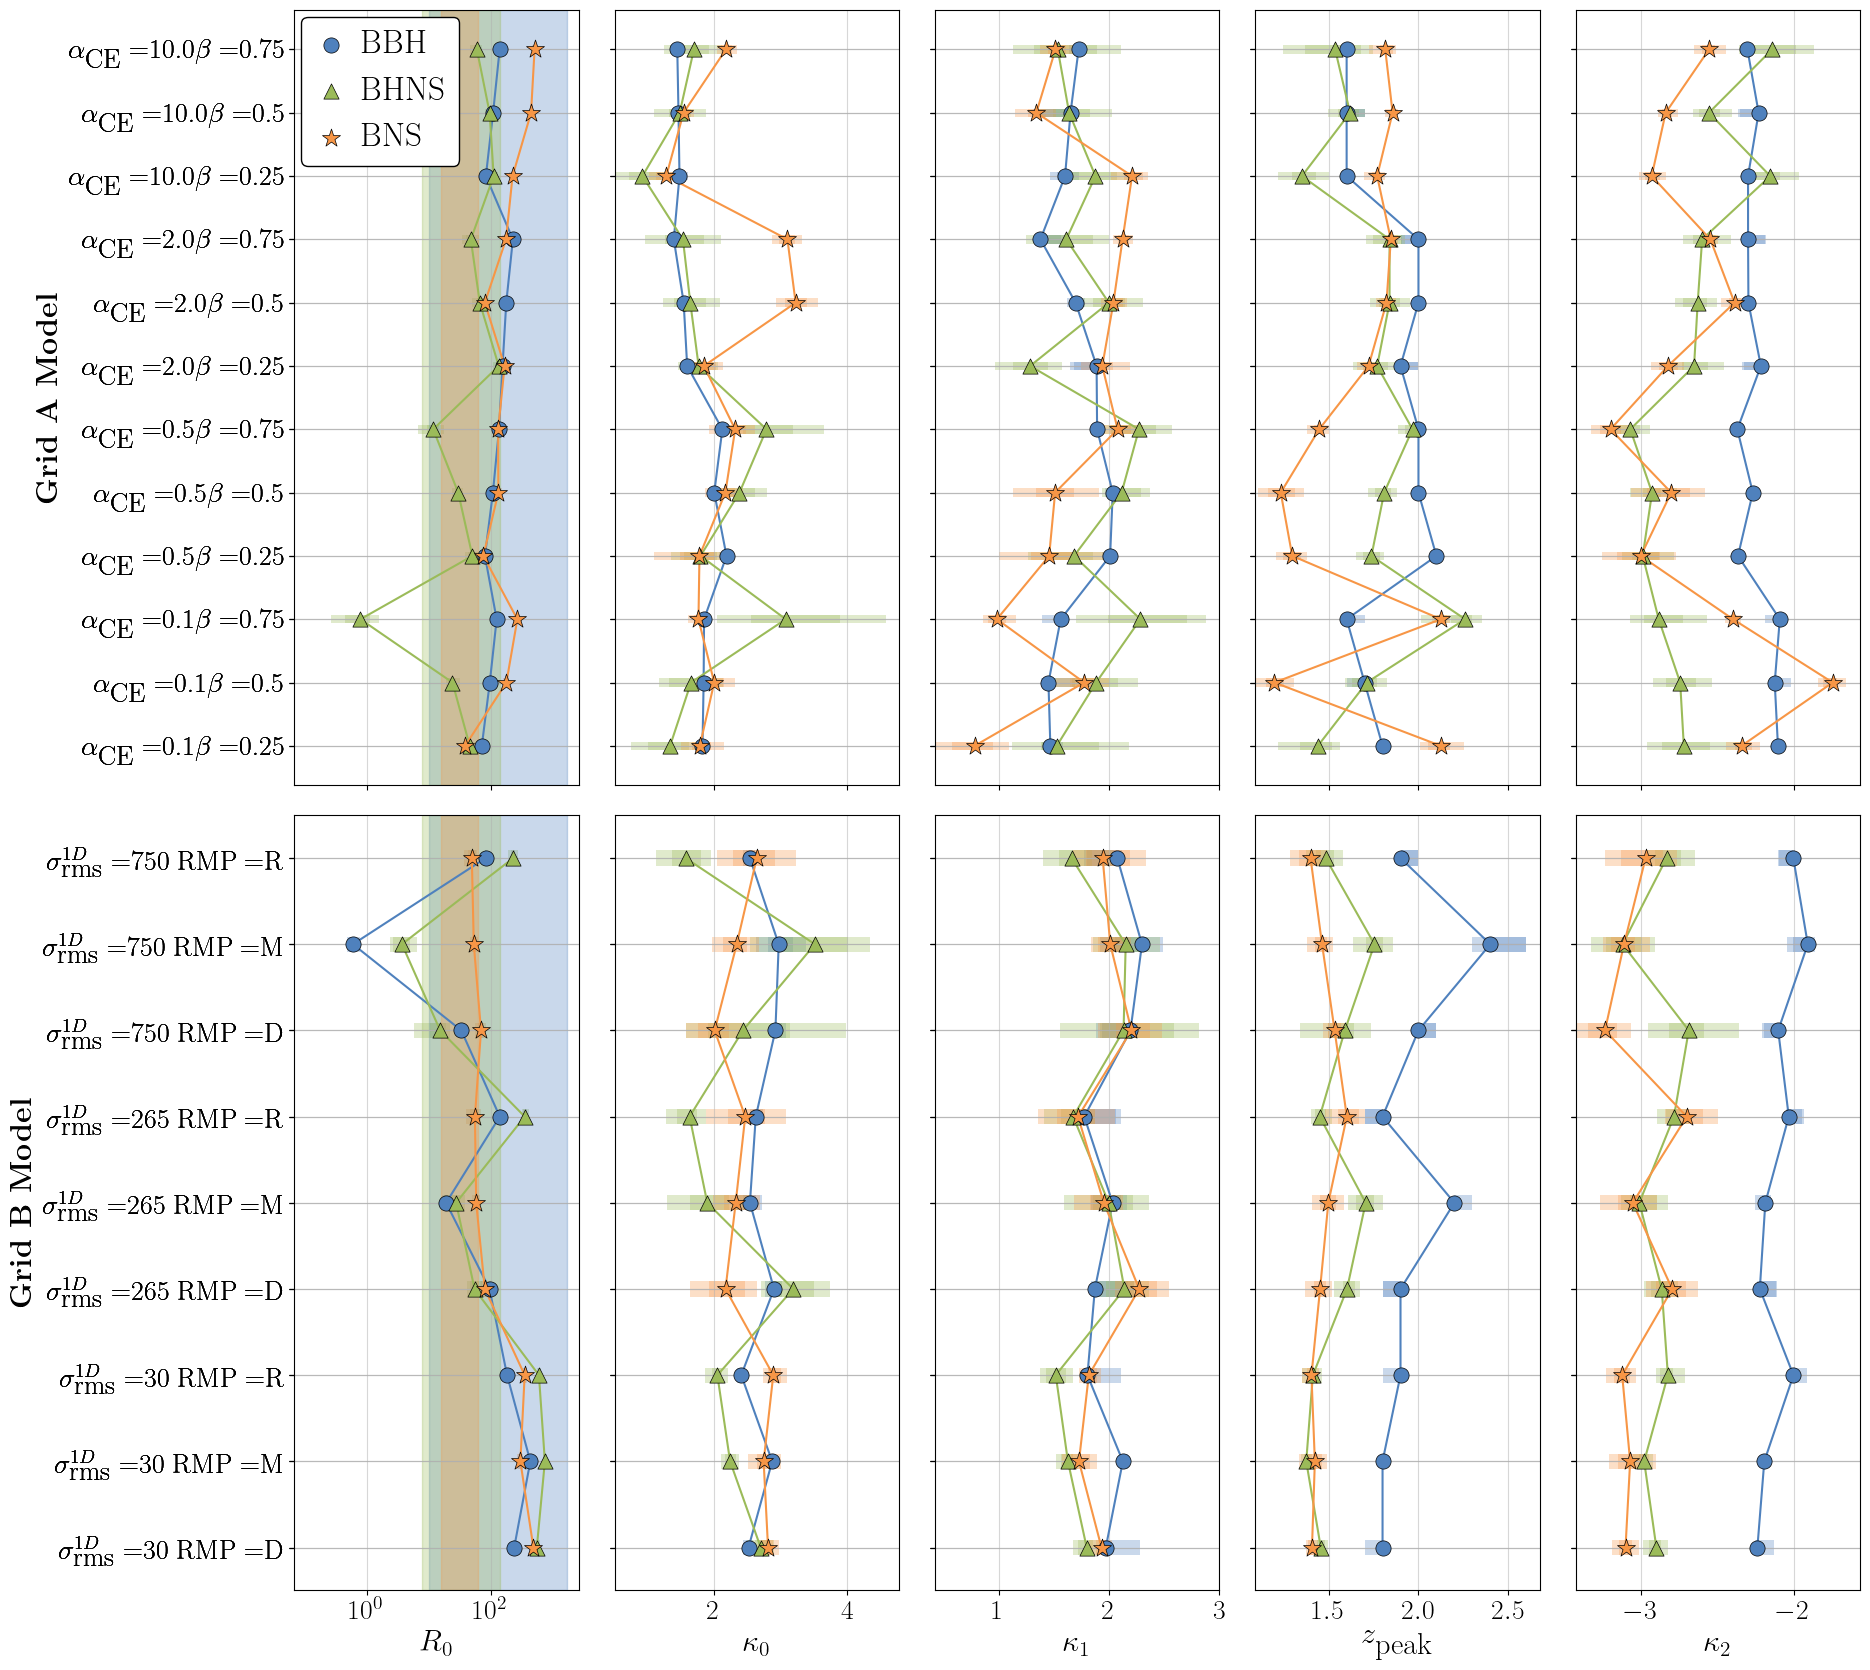

In [469]:
plot_pow_law_fits(total_formation_rates,
        	        total_merger_rates,
        	        one_sigma,
                    two_sigma,
            	    formation_rate_kappa0,
                	formation_rate_kappa1,
           		    formation_rate_kappa2,
                	merger_rate_kappa0,
            	    merger_rate_kappa1,
                	merger_rate_kappa2,
                	formation_rate_peak_zs,
                	merger_rate_peak_zs,
                	redshifts,
                	intrinsic_formation_rate,
                	intrinsic_merger_rate)
plt.savefig('Figures/pow_law_fits.pdf')
plt.show()

# Get some stats on the fits

In [925]:
def get_pct_diff(pred, true):
    return np.abs(pred - true) / np.mean([true], axis=0)

formation_pct_diffs = {}
merger_pct_diffs = {}
mean_formation_pct_diff = []
mean_merger_pct_diff = []

for i_grid, grid in enumerate(('ab', 'sr')):
    if grid == 'ab':
        p1_vals=alpha_vals
        p2_vals=beta_vals
    else:
        p1_vals=sigma_vals
        p2_vals=rmp_vals

    formation_pct_diffs[grid] = {}
    merger_pct_diffs[grid] = {}
    for dco_type in ('BBH', 'BHNS', 'BNS'):
        formation_pct_diffs[grid][dco_type] = {}
        merger_pct_diffs[grid][dco_type] = {}
        for p1_val in p1_vals:
            formation_pct_diffs[grid][dco_type][p1_val] = {}
            merger_pct_diffs[grid][dco_type][p1_val] = {}
            for p2_val in p2_vals:

                # n_tresh = int(len(formation_rate_preds[grid][dco_type][p1_val][p2_val]) * 0.2)
                formation_n_thresh = np.argmax(total_formation_rates[grid][dco_type][p1_val][p2_val])
                merger_n_thresh = np.argmax(total_merger_rates[grid][dco_type][p1_val][p2_val])

                # print(dco_type, p1_val, p2_val)
                # plt.plot(merger_rate_preds[grid][dco_type][p1_val][p2_val])
                # plt.plot((total_merger_rates[grid][dco_type][p1_val][p2_val]/max(total_merger_rates[grid][dco_type][p1_val][p2_val])))
                # plt.show()

                fpd = get_pct_diff(formation_rate_preds[grid][dco_type][p1_val][p2_val][:formation_n_thresh], (total_formation_rates[grid][dco_type][p1_val][p2_val]/max(total_formation_rates[grid][dco_type][p1_val][p2_val]))[:formation_n_thresh])
                mpd = get_pct_diff(merger_rate_preds[grid][dco_type][p1_val][p2_val][:merger_n_thresh], (total_merger_rates[grid][dco_type][p1_val][p2_val]/max(total_merger_rates[grid][dco_type][p1_val][p2_val]))[:merger_n_thresh])
                formation_pct_diffs[grid][dco_type][p1_val][p2_val] = fpd
                merger_pct_diffs[grid][dco_type][p1_val][p2_val] = mpd

                # plt.plot(fpd)
                # plt.plot(mpd)
                mean_formation_pct_diff.append(np.mean(fpd))
                mean_merger_pct_diff.append(np.mean(mpd))

In [926]:
print(np.mean(mean_formation_pct_diff), np.mean(mean_merger_pct_diff))

0.06479052779734756 0.047801147430683213


In [631]:
def dbl_brkn_pow_law(redshifts, kappa0, kappa1, kappa2, gamma0, gamma1, gamma2, max_index, R0):

    # Index of the first break
    break_index=int(max_index / 2)

    # Data broken up
    broken_redshifts = [redshifts[:break_index], redshifts[break_index:max_index], redshifts[max_index:]]

    # Calculate the rate
    rate0 = gamma0 * (1+broken_redshifts[0]) ** kappa0
    rate1 = (1+broken_redshifts[1]) ** kappa1
    rate2 = (1+broken_redshifts[2]) ** kappa2
    c_peak = 1 / (1+redshifts[max_index]) ** kappa2  # A coefficient to scale the rate after the peak
    rate = np.concatenate((rate0, rate1 * gamma1))
    # rate = np.concatenate((rate, rate2 * np.abs(rate[-1] / rate2[0])))
    rate = np.concatenate((rate, rate2 * gamma2))

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):

    # Get the index of the maximum rate
    max_index = np.argmax(rate)

    # Get the peak redshift
    peak_z = redshifts[max_index]

    # Get intrinsic rate
    R0 = rate[0]

    # Fit the data
    kappas, params_cov = curve_fit(lambda zs, kappa0, kappa1, kappa2, gamma0, gamma1, gamma2: dbl_brkn_pow_law(zs, kappa0, kappa1, kappa2, gamma0, gamma1, gamma2, max_index, R0), redshifts, rate)


    return kappas, peak_z

In [632]:
help = total_merger_rates['ab']['BNS']['0.1']['0.25']/max(total_merger_rates['ab']['BNS']['0.1']['0.25'])
ks, zpeak = dbl_get_kappa_and_peak(redshifts['ab']['BNS']['0.1']['0.25'], help)
help_fit = dbl_brkn_pow_law(redshifts['ab']['BNS']['0.1']['0.25'], ks[0], ks[1], ks[2], ks[3], ks[4], ks[5], np.argmax(help), help[0])

(0.03162277660168379, 1.25)

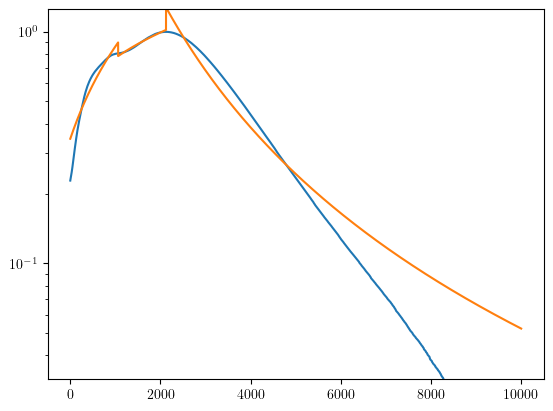

In [633]:
plt.plot(help)
plt.plot(help_fit)
plt.yscale('log')
plt.ylim((10**-1.5, 1.25))

In [621]:
def dbl_brkn_pow_law(redshifts, kappa0, kappa1, kappa2, kappa3, gamma0, gamma1, gamma2, gamma3, max_index, R0):

    # Index of the first break
    break_index=int(max_index / 2)
    break_index_2=int(max_index + (len(redshifts) - max_index)*0.2)

    # Data broken up
    broken_redshifts = [redshifts[:break_index], redshifts[break_index:max_index], redshifts[max_index:break_index_2], redshifts[break_index_2:]]

    # Calculate the rate
    rate0 = R0 * (1+broken_redshifts[0]) ** kappa0
    rate1 = (1+broken_redshifts[1]) ** kappa1
    rate2 = (1+broken_redshifts[2]) ** kappa2
    rate3 = (1+broken_redshifts[3]) ** kappa3
    c_peak = 1 / (1+redshifts[max_index]) ** kappa2  # A coefficient to scale the rate after the peak
    rate = np.concatenate((rate0, rate1 * gamma1))
    # rate = np.concatenate((rate, rate2 * np.abs(rate[-1] / rate2[0])))
    rate = np.concatenate((rate, rate2 * gamma2))
    rate = np.concatenate((rate, rate3 * gamma3))

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):

    # Get the index of the maximum rate
    max_index = np.argmax(rate)

    # Get the peak redshift
    peak_z = redshifts[max_index]

    # Get intrinsic rate
    R0 = rate[0]

    # Fit the data
    kappas, params_cov = curve_fit(lambda zs, kappa0, kappa1, kappa2, kappa3, gamma0, gamma1, gamma2, gamma3: dbl_brkn_pow_law(zs, kappa0, kappa1, kappa2, kappa3, gamma0, gamma1, gamma2, gamma3, max_index, R0), redshifts, rate)


    return kappas, peak_z

In [622]:
help = total_merger_rates['ab']['BNS']['0.1']['0.25']/max(total_merger_rates['ab']['BNS']['0.1']['0.25'])
ks, zpeak = dbl_get_kappa_and_peak(redshifts['ab']['BNS']['0.1']['0.25'], help)
help_fit = dbl_brkn_pow_law(redshifts['ab']['BNS']['0.1']['0.25'], ks[0], ks[1], ks[2], ks[3], ks[4], ks[5], ks[6], ks[7], np.argmax(help), help[0])

/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(0.03162277660168379, 1.25)

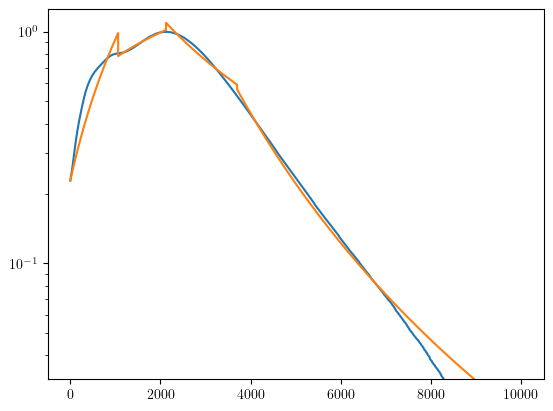

In [629]:
plt.plot(help)
plt.plot(help_fit)
plt.yscale('log')
plt.ylim((10**-1.5, 1.25))

In [883]:
def dbl_brkn_pow_law(redshifts, alpha, beta, c, scale):

    rate = scale*(1+redshifts)**alpha / (1 + ((1+redshifts) / c)**beta)

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):
    # Fit the data
    kappas, params_cov = curve_fit(lambda zs, alpha, beta, c, scale: dbl_brkn_pow_law(zs, alpha, beta, c, scale), redshifts, rate)

    return kappas

In [884]:
help = total_merger_rates['ab']['BNS']['0.1']['0.25']/max(total_merger_rates['ab']['BNS']['0.1']['0.25'])
ks = dbl_get_kappa_and_peak(redshifts['ab']['BNS']['0.1']['0.25'], help)
help_fit = dbl_brkn_pow_law(redshifts['ab']['BNS']['0.1']['0.25'], ks[0], ks[1], ks[2], ks[3])

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_85830/3745329618.py:3: RuntimeWarning: invalid value encountered in power
  rate = scale*(1+redshifts)**alpha / (1 + ((1+redshifts) / c)**beta)


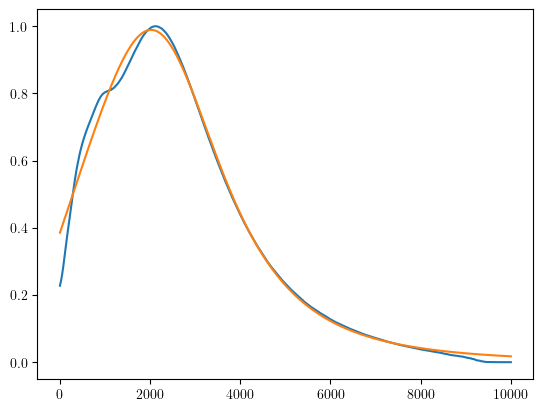

In [885]:
plt.plot(help)
plt.plot(help_fit)
# plt.yscale('log')
# plt.xlim(0, 8000)
# plt.ylim((10**-1.5, 1.25))

In [913]:
def dbl_brkn_pow_law(redshifts, kappa, alpha, beta, cf, R0):

    # Index of the break
    break_index=int(len(redshifts) * 0.1)

    # Data broken up
    broken_redshifts = [redshifts[:break_index], redshifts[break_index:]]

    # Calculate the rate
    rate    = R0*(1+broken_redshifts[0]) ** kappa
    rate1   = (1+broken_redshifts[1])**alpha / (1 + ((1+broken_redshifts[1]) / cf)**beta)
    # rate = np.concatenate((rate0, rate1 * gamma1))
    # rate = np.concatenate((rate, scale*rate1))
    rate = np.concatenate((rate, np.abs(rate[-1] / rate1[0]) * rate1))

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):
    # Fit the data
    initial_guess = [1.82478497, 0.63807875,         5.31969348, 3.90918117]
    kappas, params_cov = curve_fit(lambda zs, kappa, alpha, beta, cf: dbl_brkn_pow_law(zs, kappa, alpha, beta, cf, rate[0]), redshifts, rate, p0=initial_guess)

    return kappas

In [917]:
help = total_merger_rates['ab']['BNS']['0.1']['0.25']/max(total_merger_rates['ab']['BNS']['0.1']['0.25'])
ks = dbl_get_kappa_and_peak(redshifts['ab']['BNS']['0.1']['0.25'], help)
help_fit = dbl_brkn_pow_law(redshifts['ab']['BNS']['0.1']['0.25'], ks[0], ks[1], ks[2], ks[3], help[0])

In [918]:
print(ks)

[1.89745242 0.63807875 5.50394622 4.2582848 ]


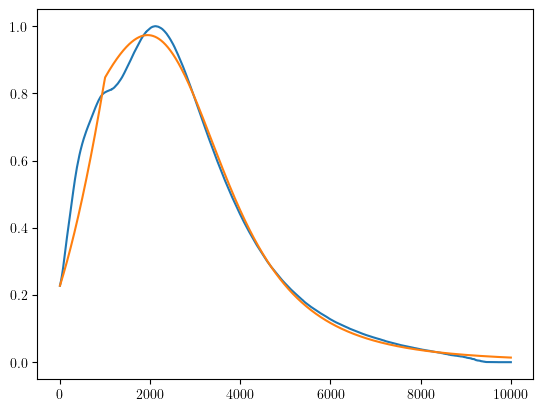

In [919]:
plt.plot(help)
plt.plot(help_fit)
# plt.xlim(0, 8000)
# plt.ylim((10**-1.5, 1.25))

In [921]:
def dbl_brkn_pow_law(redshifts, kappa, beta, cf, R0):

    # Index of the break
    break_index=int(len(redshifts) * 0.1)

    # Data broken up
    broken_redshifts = [redshifts[:break_index], redshifts[break_index:]]

    # Calculate the rate
    rate    = R0*(1+broken_redshifts[0]) ** kappa
    rate1   = (1+broken_redshifts[1]) / (1 + ((1+broken_redshifts[1]) / cf)**beta)
    # rate = np.concatenate((rate0, rate1 * gamma1))
    # rate = np.concatenate((rate, scale*rate1))
    rate = np.concatenate((rate, np.abs(rate[-1] / rate1[0]) * rate1))

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):
    # Fit the data
    initial_guess = [1.82478497,         5.31969348, 3.90918117]
    kappas, params_cov = curve_fit(lambda zs, kappa, beta, cf: dbl_brkn_pow_law(zs, kappa, beta, cf, rate[0]), redshifts, rate, p0=initial_guess)

    return kappas

In [922]:
help = total_merger_rates['ab']['BNS']['0.1']['0.25']/max(total_merger_rates['ab']['BNS']['0.1']['0.25'])
ks = dbl_get_kappa_and_peak(redshifts['ab']['BNS']['0.1']['0.25'], help)
help_fit = dbl_brkn_pow_law(redshifts['ab']['BNS']['0.1']['0.25'], ks[0], ks[1], ks[2], help[0])

In [923]:
print(ks)

[1.82478487 5.31969406 3.90918139]


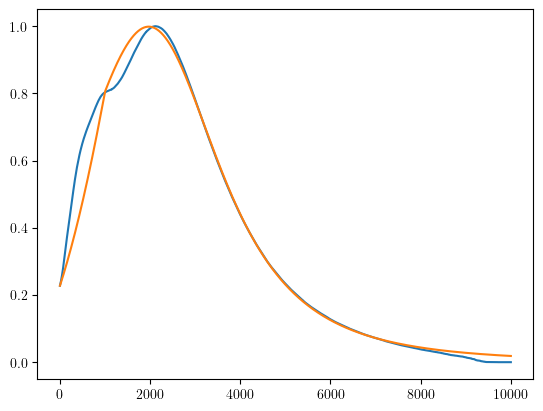

In [924]:
plt.plot(help)
plt.plot(help_fit)
# plt.xlim(0, 8000)
# plt.ylim((10**-1.5, 1.25))

# Differentials Plot

In [1222]:
def get_closest_ind(arr, val):
    closest_index  = np.argmin(np.abs(arr - val))
    return closest_index


def get_diffs(redshifts, rate):

    # Make a list of the ranges of differentials that we are interested in
    diffs = []
    peak_z = redshifts[np.argmax(rate)]
    bin_edges = [
        get_closest_ind(redshifts, 0),
        get_closest_ind(redshifts, 1),
        get_closest_ind(redshifts, peak_z),
        get_closest_ind(redshifts, peak_z+1),
        len(redshifts)-1
    ]

    # Calculate the differentials
    for i in range(len(bin_edges) - 1):
        dRdz = (rate[bin_edges[i+1]] - rate[bin_edges[i]]) / (redshifts[bin_edges[i+1]] - redshifts[bin_edges[i]])
        diffs.append(dRdz)
    return diffs, peak_z

In [1263]:
def get_rate_differentials(path_to_data, file_string, p1_vals, p2_vals):

    # Dictionaries to retrieve the data:
	total_formation_rates = {}
	total_merger_rates = {}
	one_sigma = {}
	two_sigma = {}
	formation_rate_dRdz0 = {}
	formation_rate_dRdz1 = {}
	formation_rate_dRdz2 = {}
	formation_rate_dRdz3 = {}
	merger_rate_dRdz0 = {}
	merger_rate_dRdz1 = {}
	merger_rate_dRdz2 = {}
	merger_rate_dRdz3 = {}
	formation_rate_peak_zs = {}
	merger_rate_peak_zs = {}
	redshifts = {}
	intrinsic_formation_rate = {}
	intrinsic_merger_rate = {}
	merger_rate_pred = {}
	formation_rate_pred = {}

	######################################################################
	# Retrieve the data
	index = 0
	for dco_type in ('BBH', 'BHNS', 'BNS'):
		total_formation_rates[dco_type] = {}
		total_merger_rates[dco_type] = {}
		one_sigma[dco_type] = {}
		two_sigma[dco_type] = {}
		formation_rate_dRdz0[dco_type] = {}
		formation_rate_dRdz1[dco_type] = {}
		formation_rate_dRdz2[dco_type] = {}
		formation_rate_dRdz3[dco_type] = {}
		merger_rate_dRdz0[dco_type] = {}
		merger_rate_dRdz1[dco_type] = {}
		merger_rate_dRdz2[dco_type] = {}
		merger_rate_dRdz3[dco_type] = {}
		formation_rate_peak_zs[dco_type] = {}
		merger_rate_peak_zs[dco_type] = {}
		redshifts[dco_type] = {}
		intrinsic_formation_rate[dco_type] = {}
		intrinsic_merger_rate[dco_type] = {}
		merger_rate_pred[dco_type] = {}
		formation_rate_pred[dco_type] = {}

		for p1_val in p1_vals:
			# Make the dictionary "2D"
			total_formation_rates[dco_type][p1_val] = {}
			total_merger_rates[dco_type][p1_val] = {}
			one_sigma[dco_type][p1_val] = {}
			two_sigma[dco_type][p1_val] = {}
			formation_rate_dRdz0[dco_type][p1_val] = {}
			formation_rate_dRdz1[dco_type][p1_val] = {}
			formation_rate_dRdz2[dco_type][p1_val] = {}
			formation_rate_dRdz3[dco_type][p1_val] = {}
			merger_rate_dRdz0[dco_type][p1_val] = {}
			merger_rate_dRdz1[dco_type][p1_val] = {}
			merger_rate_dRdz2[dco_type][p1_val] = {}
			merger_rate_dRdz3[dco_type][p1_val] = {}
			formation_rate_peak_zs[dco_type][p1_val] = {}
			merger_rate_peak_zs[dco_type][p1_val] = {}
			redshifts[dco_type][p1_val] = {}         
			intrinsic_formation_rate[dco_type][p1_val] = {}
			intrinsic_merger_rate[dco_type][p1_val] = {}
			merger_rate_pred[dco_type][p1_val] = {}
			formation_rate_pred[dco_type][p1_val] = {}

			for p2_val in p2_vals:
				one_sigma[dco_type][p1_val][p2_val] = {}
				two_sigma[dco_type][p1_val][p2_val] = {}
				with open(file_string.format(path_to_data, p1_val, p2_val, dco_type), 'rb') as f:

					# Get data
					h5_data = h5.File(f)
					total_formation_rates[dco_type][p1_val][p2_val] = h5_data['Actual']['total_formation_rates'][...]
					total_merger_rates[dco_type][p1_val][p2_val] = h5_data['Actual']['total_merger_rates'][...]
					redshifts[dco_type][p1_val][p2_val] = h5_data['Actual']['redshifts'][...]


					# GET RATE DIFFS, Z_PEAK, AND R0                                
					# Get the intrinsic rates
					intrinsic_formation_rate[dco_type][p1_val][p2_val] = total_formation_rates[dco_type][p1_val][p2_val][0]
					intrinsic_merger_rate[dco_type][p1_val][p2_val] = total_merger_rates[dco_type][p1_val][p2_val][0]

					# Get kappas
					# Formation rates
					formation_rate_diffs, formation_rate_peak_z = get_diffs(redshifts[dco_type][p1_val][p2_val],  total_formation_rates[dco_type][p1_val][p2_val])
					formation_rate_peak_zs[dco_type][p1_val][p2_val] = formation_rate_peak_z
					formation_rate_dRdz0[dco_type][p1_val][p2_val] = formation_rate_diffs[0]
					formation_rate_dRdz1[dco_type][p1_val][p2_val] = formation_rate_diffs[1]
					formation_rate_dRdz2[dco_type][p1_val][p2_val] = formation_rate_diffs[2]
					formation_rate_dRdz3[dco_type][p1_val][p2_val] = formation_rate_diffs[3]
					# Merger rates
					merger_rate_diffs, merger_rate_peak_z = get_diffs(redshifts[dco_type][p1_val][p2_val],  total_merger_rates[dco_type][p1_val][p2_val])
					merger_rate_peak_zs[dco_type][p1_val][p2_val] = merger_rate_peak_z
					merger_rate_dRdz0[dco_type][p1_val][p2_val] = merger_rate_diffs[0]
					merger_rate_dRdz1[dco_type][p1_val][p2_val] = merger_rate_diffs[1]
					merger_rate_dRdz2[dco_type][p1_val][p2_val] = merger_rate_diffs[2]
					merger_rate_dRdz3[dco_type][p1_val][p2_val] = merger_rate_diffs[3]


					# CONFIDENCE INTERVALS!
					# Iterate through all the bootstrapped rates and calculate the kappa values for the rates
					formation_rate_dRdz0s = []
					formation_rate_dRdz1s = []
					formation_rate_dRdz2s = []
					formation_rate_dRdz3s = []
					formation_rate_peaks = []
					merger_rate_dRdz0s = []
					merger_rate_dRdz1s = []
					merger_rate_dRdz2s = []
					merger_rate_dRdz3s = []
					merger_rate_peaks = []
					intrinsic_formation_rates = []
					intrinsic_merger_rates = []
					for rate_index in range(len(h5_data['Bootstraps']['total_formation_rates'][...])):

						# Get the akppa for the current bootstrap iteration
						if np.argmax(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]) != 0 and np.argmax(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0

							# Get the kappas and peaks
							formation_rate_diffs_bs, formation_rate_peak = get_diffs(redshifts[dco_type][p1_val][p2_val], h5_data['Bootstraps']['total_formation_rates'][...][rate_index])
							merger_rate_diffs_bs, merger_rate_peak = get_diffs(redshifts[dco_type][p1_val][p2_val], h5_data['Bootstraps']['total_merger_rates'][...][rate_index])

							# Store the kappas
							formation_rate_dRdz0s.append(formation_rate_diffs_bs[0])
							formation_rate_dRdz1s.append(formation_rate_diffs_bs[1])
							formation_rate_dRdz2s.append(formation_rate_diffs_bs[2])
							formation_rate_dRdz3s.append(formation_rate_diffs_bs[3])
							merger_rate_dRdz0s.append(merger_rate_diffs_bs[0])
							merger_rate_dRdz1s.append(merger_rate_diffs_bs[1])
							merger_rate_dRdz2s.append(merger_rate_diffs_bs[2])
							merger_rate_dRdz3s.append(merger_rate_diffs_bs[3])

							# Store the peaks
							formation_rate_peaks.append(formation_rate_peak)
							merger_rate_peaks.append(merger_rate_peak)

							# Get the intrinsic rates
							intrinsic_formation_rates.append(h5_data['Bootstraps']['total_formation_rates'][...][rate_index][0])
							intrinsic_merger_rates.append(h5_data['Bootstraps']['total_merger_rates'][...][rate_index][0])


					# Get and store the confidence intervals for the kappas
					# Formation rates
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_diff0']         = np.percentile(formation_rate_dRdz0s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_diff1']         = np.percentile(formation_rate_dRdz1s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_diff2']         = np.percentile(formation_rate_dRdz2s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_diff3']         = np.percentile(formation_rate_dRdz3s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_diff0']         = np.percentile(formation_rate_dRdz0s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_diff1']         = np.percentile(formation_rate_dRdz1s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_diff2']         = np.percentile(formation_rate_dRdz2s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_diff3']         = np.percentile(formation_rate_dRdz3s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
					# Merger rates
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_diff0']            = np.percentile(merger_rate_dRdz0s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_diff1']            = np.percentile(merger_rate_dRdz1s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_diff2']            = np.percentile(merger_rate_dRdz2s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_diff3']            = np.percentile(merger_rate_dRdz3s, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
					one_sigma[dco_type][p1_val][p2_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_diff0']            = np.percentile(merger_rate_dRdz0s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_diff1']            = np.percentile(merger_rate_dRdz1s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_diff2']            = np.percentile(merger_rate_dRdz2s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_diff3']            = np.percentile(merger_rate_dRdz3s, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
					two_sigma[dco_type][p1_val][p2_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])

	return (total_formation_rates,
			total_merger_rates,
			one_sigma,
			two_sigma,
			formation_rate_dRdz0,
			formation_rate_dRdz1,
			formation_rate_dRdz2,
			formation_rate_dRdz3,
			merger_rate_dRdz0,
			merger_rate_dRdz1,
			merger_rate_dRdz2,
			merger_rate_dRdz3,
			formation_rate_peak_zs,
			merger_rate_peak_zs,
			redshifts,
			intrinsic_formation_rate,
			intrinsic_merger_rate)


def plot_rate_differentials(total_formation_rates,
					total_merger_rates,
					one_sigma,
					two_sigma,
					formation_rate_dRdz0,
					formation_rate_dRdz1,
					formation_rate_dRdz2,
					formation_rate_dRdz3,
					merger_rate_dRdz0,
					merger_rate_dRdz1,
					merger_rate_dRdz2,
					merger_rate_dRdz3,
					formation_rate_peak_zs,
					merger_rate_peak_zs,
					redshifts,
					intrinsic_formation_rate,
					intrinsic_merger_rate):

	index = 0
	dy = 0.8
	labels = []
	label_indexs = []
	dco_markers = {
		'BBH': 'o',
		'BHNS': '^',
		'BNS': '*'
	}
	dco_marker_sizes = {
		'BBH': 120,
		'BHNS': 120,
		'BNS': 185
	}


	######################################################################
	# Plot the merger rate kappas and z_peak
    # Create a figure
	merger_fig = plt.figure(figsize=(23, 17))
	# Create axes for the first row and store them in a list
	axes_first_row = [merger_fig.add_subplot(2, 6, i + 1) for i in range(6)]
	# Create axes for the second row, sharing x-axis with corresponding first row axes
	axes_second_row = [merger_fig.add_subplot(2, 6, i + 7, sharex=ax) for i, ax in enumerate(axes_first_row)]
	# Merge the two lists of axes into a 2D list
	merger_axes = np.array([axes_first_row, axes_second_row])

	# Make grid in background
	for i in range(2):
		merger_axes[i, 0].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 1].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 2].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 3].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 4].grid(alpha=0.5, zorder=-1)
		merger_axes[i, 5].grid(alpha=0.5, zorder=-1)


	for i_grid, grid in enumerate(('ab', 'sr')):

		# Param vars based on grid
		if grid == 'ab':
			p1_vals = alpha_vals
			p2_vals = beta_vals
		else:
			p1_vals = sigma_vals
			p2_vals = rmp_vals
		dylen = (2*dy)/(len(p1_vals)*len(p2_vals))
		index = 0
		labels = []
		lab_tups = []
		label_indexs = []
		legend_pts = []

		for dco_type in ('BBH', 'BHNS', 'BNS'):
			xs = []
			ys = []
			for p1_val in p1_vals:
				for p2_val in p2_vals:

					# Store the x and y values for the line plot
					xs.append([
						intrinsic_merger_rate[grid][dco_type][p1_val][p2_val],
						merger_rate_dRdz0[grid][dco_type][p1_val][p2_val],
						merger_rate_dRdz1[grid][dco_type][p1_val][p2_val],
						merger_rate_peak_zs[grid][dco_type][p1_val][p2_val],
						merger_rate_dRdz2[grid][dco_type][p1_val][p2_val],
						merger_rate_dRdz3[grid][dco_type][p1_val][p2_val]
					])
					ys.append(index)

					# Plot the intrinsic rate
					scatter_pt = merger_axes[i_grid, 0].scatter(x=intrinsic_merger_rate[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type], label=dco_type)                                             	   	# Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 1sigma error bar
					merger_axes[i_grid, 0].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)             				# 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 2sigma error bar
					merger_axes[i_grid, 0].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['intrinsic_merger_rate'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)             				# 2sigma error bar

					# Plot diff0
					merger_axes[i_grid, 1].scatter(x=merger_rate_dRdz0[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                   # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff0'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff0'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 1].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff0'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff0'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff0'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 1].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff0'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Plot diff1
					merger_axes[i_grid, 2].scatter(x=merger_rate_dRdz1[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                   # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff1'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff1'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 2].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff1'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff1'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff1'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 2].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff1'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Plot z_max
					merger_axes[i_grid, 3].scatter(x=merger_rate_peak_zs[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                  # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 3].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 3].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_peak_z'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Plot diff2
					merger_axes[i_grid, 4].scatter(x=merger_rate_dRdz2[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                   # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff2'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff2'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 4].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff2'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff2'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff2'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 4].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff2'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Plot diff3
					merger_axes[i_grid, 5].scatter(x=merger_rate_dRdz3[grid][dco_type][p1_val][p2_val], y=index, s=dco_marker_sizes[dco_type], color=color_grid_dcos[dco_type], alpha=1, zorder=100, edgecolor='k', linewidth=0.5, marker=dco_markers[dco_type])                                                   # Point at estimated value
					width = one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff3'][1] - one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff3'][0]                                                                       # Get the width of the 1sigma error bar
					merger_axes[i_grid, 5].barh(index, width=width, left=one_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff3'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
					width = two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff3'][1] - two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff3'][0]                                                                       # Get the width of the 2sigma error bar
					merger_axes[i_grid, 5].barh(index, width=width, left=two_sigma[grid][dco_type][p1_val][p2_val]['merger_rate_diff3'][0], color=color_grid_dcos[dco_type], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

					# Add model values to the labels list
					# if grid == 'ab':
						# labels.append(r'$\alpha_{\textrm{CE}} = $' + p1_val + r'$\beta = $' + p2_val)
					# else:
						# labels.append(r'$\sigma_{\textrm{rms}}^{1D} = $' + p1_val + r'$\textrm{ RMP} = $' + p2_val)
					# pad = ''
					# for _ in range(10 - len(p2_val)-len(p2_val)):
					# 	pad += r'$\ $'
					# labels.append(p1_val + pad + p2_val)
					label_indexs.append(index)
					labels.append('')
					lab_tups.append((index, p1_val, p2_val))

					# Append point for legend
					if index == 0:
						legend_pts.append(scatter_pt)
					index+=1

			# Add lines connecting the points
			xs = np.array(xs)
			for i_line in range(6):
				merger_axes[i_grid, i_line].plot(xs[:, i_line], ys, color=color_grid_dcos[dco_type])
			index = 0

		for ax_index, ax in enumerate(merger_axes[i_grid].flatten()):
			ax.tick_params(labelsize=20)
			ax.set_yticks(label_indexs)
			if ax_index == 0:       
				ax.set_yticklabels(labels)
			else:
				ax.set_yticklabels(['' for i in range(len(labels))])
		

		# Add model labels
		for lab_tup in lab_tups:
			merger_axes[i_grid, 0].text(0.0005, lab_tup[0], lab_tup[1], fontsize=22, ha='left', va='center', zorder=100000)
			merger_axes[i_grid, 0].text(0.0075, lab_tup[0], lab_tup[2], fontsize=22, ha='left', va='center', zorder=100000)

	# # Plot SFR values
	# merger_axes[1].axvline(x=sfr_kappa0, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr
	# merger_axes[2].axvline(x=sfr_kappa1, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa1 for the sfr
	# merger_axes[3].axvline(x=sfr_peak_redshift, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                    # Plot kappa0 for the sfr
	# merger_axes[4].axvline(x=sfr_kappa2, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr

	# # Add 90% confidence interval from 03 Ligo/Virgo 2022; The population of merging compact...
	# if dco_type == 'BNS':
	#         merger_axes[0].axvspan(10, 1700, alpha=0.3, color='gray', zorder=-1)
	# elif dco_type == 'BHNS':
	#         merger_axes[0].axvspan(7.8, 140, alpha=0.3, color='gray', zorder=-1)
	# elif dco_type == 'BBH':
	#         merger_axes[0].axvspan(16, 61, alpha=0.3, color='gray', zorder=-1)
	merger_axes[0, 0].set_xscale('log')
	for dco_type, lower_bound, upper_bound in zip(['BBH', 'BHNS', 'BNS'], [10, 7.8, 16], [1700, 140, 61]):
		merger_axes[0, 0].axvspan(lower_bound, upper_bound, alpha=0.3, color=color_grid_dcos[dco_type], zorder=-1)
		merger_axes[1, 0].axvspan(lower_bound, upper_bound, alpha=0.3, color=color_grid_dcos[dco_type], zorder=-1)
	xlims = merger_axes[0, 0].get_xlim()
	merger_axes[0, 0].set_xlim((xlims[0]-0.2, xlims[1]))


	# Label axes of all the plots
	merger_axes[1, 0].set_xlabel(r'$R_0$', fontsize=22)
	# merger_axes[1, 1].set_xlabel(r'$\kappa_0$', fontsize=22)
	# merger_axes[1, 2].set_xlabel(r'$\kappa_1$', fontsize=22)
	merger_axes[1, 1].set_xlabel(r'$\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (0, 1)$', fontsize=22)
	merger_axes[1, 2].set_xlabel(r'$\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (1, z_{\rm{peak}})$', fontsize=22)
	merger_axes[1, 3].set_xlabel(r'$z_\textrm{peak}$', fontsize=22)
	merger_axes[1, 4].set_xlabel(r'$\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (z_{\rm{peak}}, z_{\rm{peak}} + 1)$', fontsize=22)
	merger_axes[1, 5].set_xlabel(r'$\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (z_{\rm{peak}} + 1, 10)$', fontsize=22)

	# Drop ticks on the top row
	for ax in merger_axes[0]:
		ax.tick_params(labelbottom=False)

	plt.tight_layout(pad=1.8)

	merger_axes[0, 0].set_ylabel(r'\textbf{Grid A Model}', fontsize=22, labelpad=120)
	merger_axes[1, 0].set_ylabel(r'\textbf{Grid B Model}', fontsize=22, labelpad=120)

	merger_axes[0, 0].legend(handles=legend_pts, fontsize=24, loc="upper left", ncol=1, edgecolor='k', handletextpad=0.4, handlelength=1.0, framealpha=1.0, borderaxespad=0.2)
	merger_axes[0, 0].text(0.046, 0.98, r'$\boldsymbol{\alpha}_{\textbf{CE}} \ \ \ \ \boldsymbol{\beta}$', fontsize=22, ha='right', va='bottom', transform=plt.gcf().transFigure)
	merger_axes[0, 0].text(0.06, 0.507, r'$\boldsymbol{\sigma}_{\textbf{rms}}^{\textbf{1D}} \ \textbf{RMP}$', fontsize=22, ha='right', va='bottom', transform=plt.gcf().transFigure)

In [1224]:
total_formation_rates = {}
total_merger_rates = {}
one_sigma = {}
two_sigma = {}
formation_rate_dRdz0 = {}
formation_rate_dRdz1 = {}
formation_rate_dRdz2 = {}
formation_rate_dRdz3 = {}
merger_rate_dRdz0 = {}
merger_rate_dRdz1 = {}
merger_rate_dRdz2 = {}
merger_rate_dRdz3 = {}
formation_rate_peak_zs = {}
merger_rate_peak_zs = {}
redshifts = {}
intrinsic_formation_rate = {}
intrinsic_merger_rate = {}
file_strings = ['{}output_alpha_CE_{}_beta_{}/Pickled_Rates/MSSFR_111/{}/rates_and_bootstraps.h5', '{}output_sigma_{}_remnant_prescription_{}/Pickled_Rates/MSSFR_111/{}/rates_and_bootstraps.h5']

for grid, path, p1_vals, p2_vals, fstring in zip(['ab', 'sr'], [path_to_ab_data, path_to_sr_data], [alpha_vals, sigma_vals], [beta_vals, rmp_vals], file_strings):
    (total_formation_rates[grid],
    total_merger_rates[grid],
    one_sigma[grid],
    two_sigma[grid],
    formation_rate_dRdz0[grid],
    formation_rate_dRdz1[grid],
    formation_rate_dRdz2[grid],
    formation_rate_dRdz3[grid],
    merger_rate_dRdz0[grid],
    merger_rate_dRdz1[grid],
    merger_rate_dRdz2[grid],
    merger_rate_dRdz3[grid],
    formation_rate_peak_zs[grid],
    merger_rate_peak_zs[grid],
    redshifts[grid],
    intrinsic_formation_rate[grid],
    intrinsic_merger_rate[grid]) = get_rate_differentials(path, fstring, p1_vals, p2_vals)

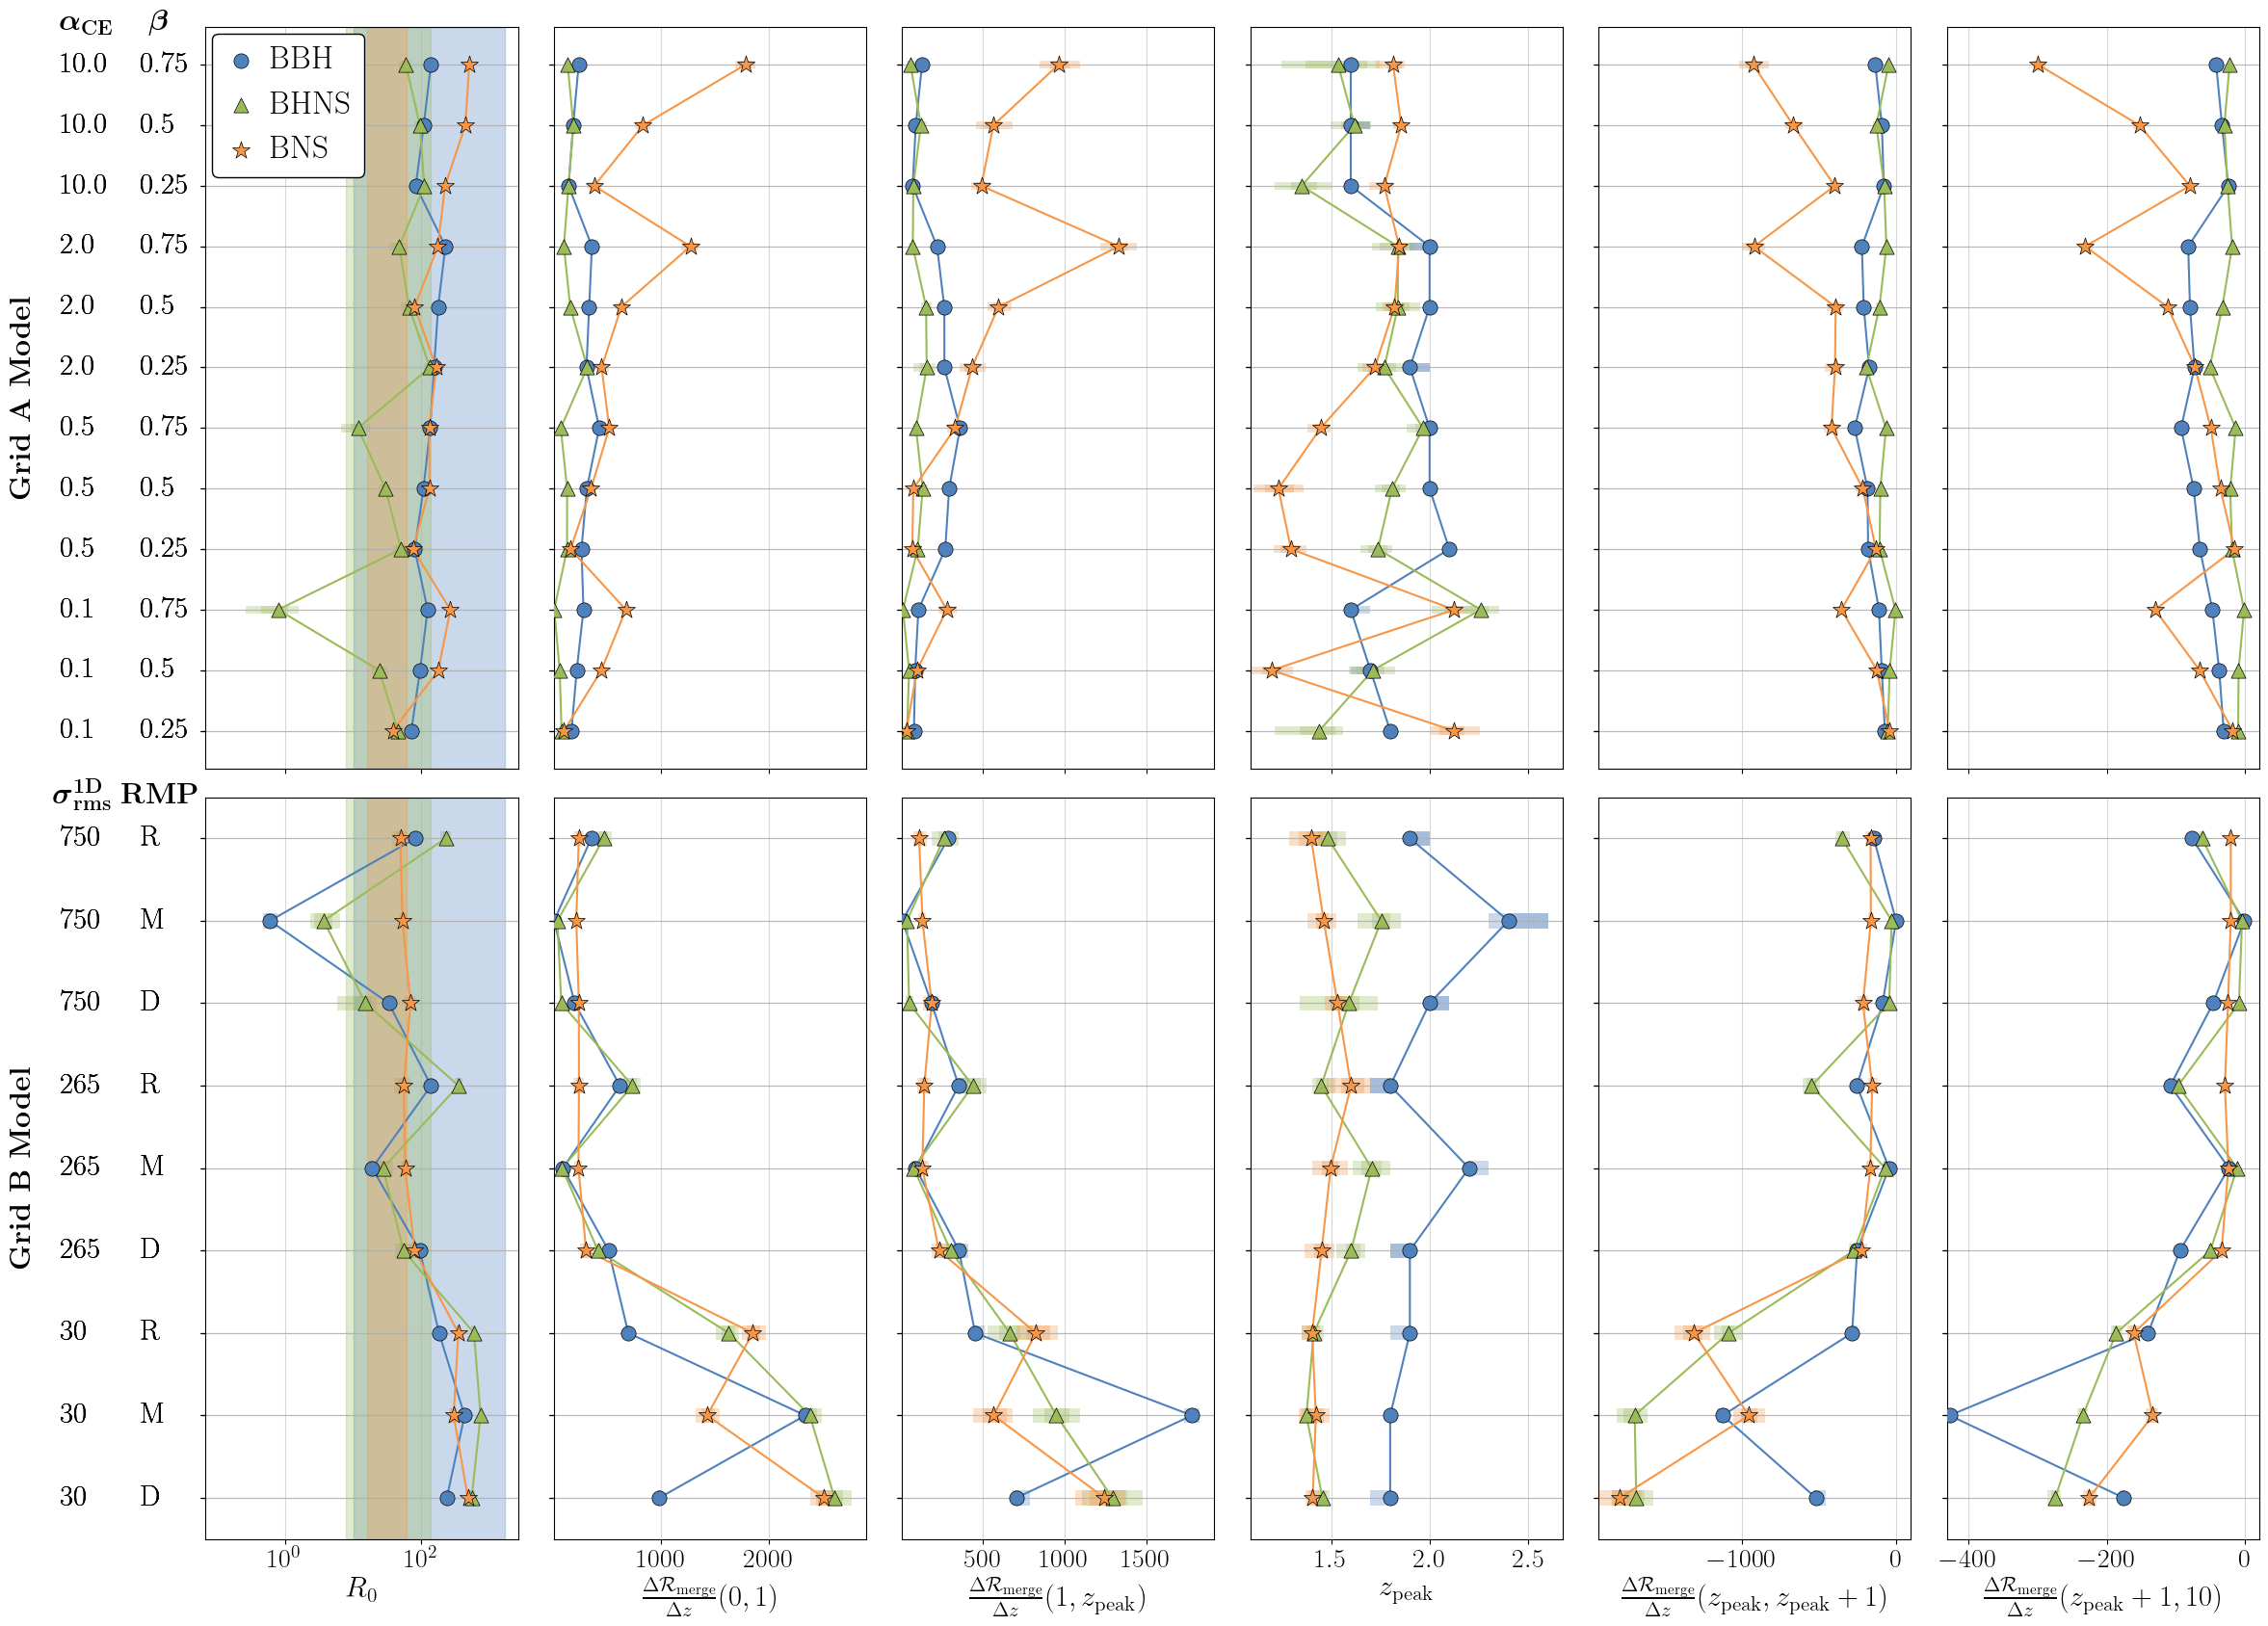

In [1264]:
plot_rate_differentials(total_formation_rates,
    total_merger_rates,
    one_sigma,
    two_sigma,
    formation_rate_dRdz0,
    formation_rate_dRdz1,
    formation_rate_dRdz2,
    formation_rate_dRdz3,
    merger_rate_dRdz0,
    merger_rate_dRdz1,
    merger_rate_dRdz2,
    merger_rate_dRdz3,
    formation_rate_peak_zs,
    merger_rate_peak_zs,
    redshifts,
    intrinsic_formation_rate,
    intrinsic_merger_rate)
plt.savefig('Figures/all_differentials.pdf', bbox_inches='tight')
plt.show()

In [1390]:
# Put the values in a csv
grid_A_cols = ['DCO_type', 'alpha_CE', 'beta', 'R_0', 'diff_0_1', 'diff_1_zp', 'z_peak', 'diff_zp_zp+1', 'diff_zp+1_10']
grid_B_cols = ['DCO_type', 'sigma_RMS', 'RMP', 'R_0', 'diff_0_1', 'diff_1_zp', 'z_peak', 'diff_zp_zp+1', 'diff_zp+1_10']
grid_A_df = pd.DataFrame(columns=grid_A_cols)
grid_B_df = pd.DataFrame(columns=grid_B_cols)
for dco_type in ('BBH', 'BHNS', 'BNS'):
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            new_row = pd.DataFrame(columns=grid_A_cols, data=[[dco_type, alpha_val, beta_val, intrinsic_merger_rate['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz0['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz1['ab'][dco_type][alpha_val][beta_val], merger_rate_peak_zs['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz2['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz3['ab'][dco_type][alpha_val][beta_val]]])
            grid_A_df = pd.concat((grid_A_df, new_row), ignore_index=True)

    for sigma_val in sigma_vals:
        for rmp_val in rmp_vals:
            new_row = pd.DataFrame(columns=grid_B_cols, data=[[dco_type, sigma_val, rmp_val, intrinsic_merger_rate['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz0['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz1['ab'][dco_type][alpha_val][beta_val], merger_rate_peak_zs['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz2['ab'][dco_type][alpha_val][beta_val], merger_rate_dRdz3['ab'][dco_type][alpha_val][beta_val]]])
            grid_B_df = pd.concat((grid_B_df, new_row), ignore_index=True)

In [1398]:
# Write a csv
with pd.ExcelWriter('Figures/all_differentials.xlsx') as writer:

    # Write each DataFrame to a different sheet
    grid_A_df.to_excel(writer, sheet_name='grid_A')
    grid_B_df.to_excel(writer, sheet_name='grid_B')

In [1375]:
# PRINTING THE VALUES
# Header
print(r"$\alpaCE$    &    $\beta$    &    $\mathcal{R}_0$    &    $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (0, 1)$    &    $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (1, z_{\rm{peak}})$    &    $z_{\rm{peak}}$    &    $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (z_{\rm{peak}}, z_{\rm{peak}} + 1)$    &    $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (z_{\rm{peak}} + 1, 10)$  \\ \hline  \hline")

# Body
for alpha_val in alpha_vals:
    for beta_val in beta_vals:
        print(fr"${alpha_val}$    &    ${beta_val}$    &   {intrinsic_merger_rate['ab']['BBH']}\\ \hline")

$\alpaCE$ \t & $\beta$ \t & $\mathcal{R}_0$ \t & $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (0, 1)$ \t & $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (1, z_{\rm{peak}})$ \t & $z_{\rm{peak}}$ \t & $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (z_{\rm{peak}}, z_{\rm{peak}} + 1)$ \t & $\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (z_{\rm{peak}} + 1, 10)$  \\ \hline  \hline


# Differentials as a function of a param

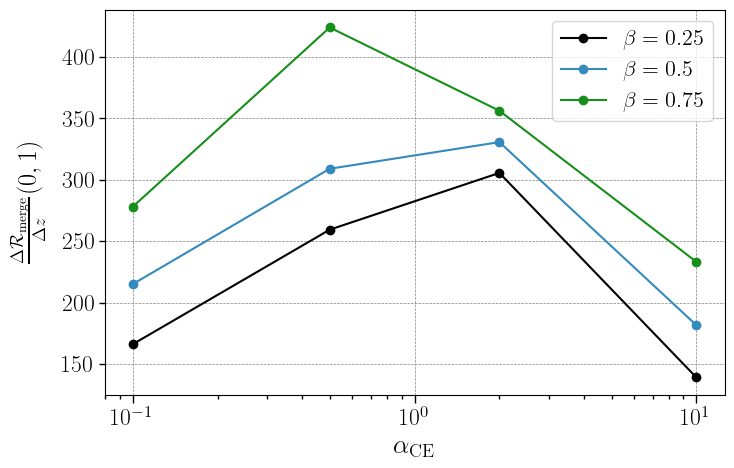

In [1368]:
# Params for plot
diff = merger_rate_dRdz0
dco_type = 'BBH'

# Plot
fig, ax = plt.subplots(figsize=(8, 5))  # Create a figure containing a single axes.
lines = []
for beta_val in beta_vals:
    lines.append([])
    for alpha_val in alpha_vals:
        lines[-1].append(merger_rate_dRdz0['ab']['BBH'][alpha_val][beta_val])

xs, ys = np.array([[float(v) for v in alpha_vals] for r in range(len(lines))]), np.array(lines)
for x, y, ls, m, col, lab in zip(xs, ys, ['-', '-', '-'], ['o', 'o', 'o'], ['k', '#348ABD', '#178F1B'], [fr'$\beta = {b}$' for b in beta_vals]):
    ax.plot(x, y, linestyle=ls, marker=m, color=col, label=lab)
ax.legend(fontsize=16)
ax.set_xscale('log')
ax.tick_params(labelsize=17, length=6, width=1, axis='x')
ax.tick_params(labelsize=17, length=4, width=1, axis='y')
ax.tick_params(which='minor', length=3, width=1)
ax.grid(color='gray', linestyle='--', lw=0.5)
ax.set_xlabel(r'$\alpha_{\rm{CE}}$', fontsize=19)
ax.set_ylabel(r'$\frac{\Delta \mathcal{R}_{\rm{merge}}}{\Delta z} (0, 1)$', fontsize=19, labelpad=12)
plt.savefig('Figures/diff_as_func.pdf', bbox_inches='tight')
plt.show()